## ICU Length of stay using  LightGBM Model & Tranformer Models

In [2]:
import math
#import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
#import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


#from tensorflow.keras.callbacks import EarlyStopping

#from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
#from tabtransformertf.utils.preprocessing import df_to_dataset

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')
## reading careplans csv


In [4]:
devices = pd.read_csv("100k_synthea_covid19_csv/devices.csv")
devices_test = pd.read_csv("10k_synthea_covid19_csv/devices.csv")

imaging_studies = pd.read_csv("100k_synthea_covid19_csv/imaging_studies.csv")
imaging_studies_test = pd.read_csv("10k_synthea_covid19_csv/imaging_studies.csv")

immunizations = pd.read_csv("100k_synthea_covid19_csv/immunizations.csv")
immunizations_test = pd.read_csv("10k_synthea_covid19_csv/immunizations.csv")

medications = pd.read_csv("100k_synthea_covid19_csv/medications.csv")
medications_test = pd.read_csv("10k_synthea_covid19_csv/medications.csv")

providers = pd.read_csv("100k_synthea_covid19_csv/providers.csv")
providers_test = pd.read_csv("covid/10k_synthea_covid19_csv/providers.csv")

allergies = pd.read_csv("100k_synthea_covid19_csv/allergies.csv")
allergies_test = pd.read_csv("covid/10k_synthea_covid19_csv/allergies.csv")

conditions = pd.read_csv("100k_synthea_covid19_csv/conditions.csv")
conditions_test = pd.read_csv("10k_synthea_covid19_csv/conditions.csv")

patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")

encounters = pd.read_csv("100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("10k_synthea_covid19_csv/encounters.csv")


In [5]:
def patients_reader(data, goal):
    data.DEATHDATE.fillna("2021-01-01", inplace = True) 
    data.DEATHDATE = pd.to_datetime(data["DEATHDATE"])
    data.BIRTHDATE =  pd.to_datetime(data["BIRTHDATE"])
    data["age"] =data.DEATHDATE- data.BIRTHDATE
    data['age'] = data.age.astype('timedelta64[Y]').astype('int')
    data["healthcare_coverage_ratio"] = data.HEALTHCARE_COVERAGE / data.HEALTHCARE_EXPENSES
    data["dataset"] = goal
    data.MARITAL.fillna("S", inplace = True)
    data.drop_duplicates(inplace = True) 
    data = data[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
    #data = data.rename(columns = {"Id": "patient"})
    return data

patients = pd.read_csv("covid/100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("covid/10k_synthea_covid19_csv/patients.csv")
patients = patients_reader(patients, "train")
patients_test = patients_reader(patients_test, "test")

In [6]:
def icu_preparation(encounter, condition, patient):
    covid_patient_ids = condition[condition.CODE == 840539006].PATIENT.unique()
    covid_conditions = condition[condition.CODE == 840539006]
    cp = covid_conditions.merge(patient, how='left', left_on='PATIENT', right_on='Id')
    icu_ids = encounter[encounter.CODE == 305351004].PATIENT
    cp['icu_admit'] = cp.Id.isin(icu_ids)
    icu_only = cp[cp.icu_admit == True]
    icu_only.START = pd.to_datetime(icu_only.START)
    icu_only.STOP = pd.to_datetime(icu_only.STOP)
    icu_only["duration"] = (icu_only.STOP - icu_only.START).dt.days
    icu_only = icu_only.loc[icu_only.STOP.notnull()].reset_index(drop = True)
    #icu_only["age"] = pd.to_datetime(icu_only["DEATHDATE"]) - pd.to_datetime(icu_only["BIRTHDATE"])
    #icu_only["healthcare_coverage_ratio"] = icu_only.HEALTHCARE_COVERAGE / icu_only.HEALTHCARE_EXPENSES
    needed_columns = ["START", "STOP", "PATIENT", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio" ,
                      "duration"]

    df = icu_only[needed_columns]
    return df

In [7]:
df = icu_preparation(encounters, conditions, patients)
test = icu_preparation(encounters_test, conditions_test, patients_test)

In [8]:
df.head()

,START,STOP,PATIENT,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,duration
0,2020-03-10,2020-03-27,a2a8e809-cc34-4f8e-93b8-74e4a87f35ef,M,white,nonhispanic,M,Somerville,Middlesex County,0.005663,17.0
1,2020-03-11,2020-03-25,30ce94e8-8c50-4588-97f6-b8aa1df0e9d2,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004333,14.0
2,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,19.0
3,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,18.0
4,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,18.0


In [9]:
df = df.rename(columns = {"START" : "icu_start", "STOP" : "icu_stop"})
test = test.rename(columns = {"START" : "icu_start", "STOP" : "icu_stop"})

In [10]:
def patients_reader(data, goal):
    data.DEATHDATE.fillna("2021-01-01", inplace = True) 
    data.DEATHDATE = pd.to_datetime(data["DEATHDATE"])
    data.BIRTHDATE =  pd.to_datetime(data["BIRTHDATE"])
    data["age"] =data.DEATHDATE- data.BIRTHDATE
    data['age'] = data.age.astype('timedelta64[Y]').astype('int')
    data["healthcare_coverage_ratio"] = data.HEALTHCARE_COVERAGE / data.HEALTHCARE_EXPENSES
    data["dataset"] = goal
    data.MARITAL.fillna("S", inplace = True)
    data.drop_duplicates(inplace = True) 
    data = data[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
    #data = data.rename(columns = {"Id": "patient"})
    return data

In [11]:
patients = pd.read_csv("covid/100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("covid/10k_synthea_covid19_csv/patients.csv")
patients = patients_reader(patients, "train")
patients_test = patients_reader(patients_test, "test")

In [12]:
def mode_finder(x): 
    m = pd.Series.mode(x); 
    return m.values[0] if not m.empty else np.nan

In [13]:
# Careplan

careplan_df = pd.read_csv("covid/100k_synthea_covid19_csv/careplans.csv")
careplan_df_test = pd.read_csv("covid/10k_synthea_covid19_csv/careplans.csv")

careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace(")", ""))

careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace(")", ""))

def careplan_reader(data, goal):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "REASONDESCRIPTION"]]
    data.columns = ["patient", "careplan_start", "careplan_end", "careplan_desc", "careplan_reason"]
    if goal == "train":
        for i in data.careplan_desc.value_counts().index[:10]:
            name = i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
      for i in careplan_df.careplan_desc.value_counts().index[:10]:
            name =  i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    data["patient's most seen careplan"] = data.groupby("patient")["careplan_desc"].transform(mode_finder)
    data = data.loc[data.careplan_reason == "COVID-19"].reset_index(drop = True)
        
    
    data["dataset"] = goal
    
    data.drop_duplicates(inplace = True) 
    return data

careplan_df = careplan_reader(careplan_df, "train")
careplan_df_test = careplan_reader(careplan_df_test, "test")

In [14]:
df = df.rename(columns = {"PATIENT" : "patient"})
test = test.rename(columns = {"PATIENT" : "patient"})

In [15]:

careplan_df = pd.merge(careplan_df, df,  on='patient', how = "right")

careplan_df_test = pd.merge(careplan_df_test, test,  on='patient', how = "right")

In [16]:
#Conditions

conditions_df = pd.read_csv("covid/100k_synthea_covid19_csv/conditions.csv")
conditions_df_test = pd.read_csv("covid/10k_synthea_covid19_csv/conditions.csv")

conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace("(","")
conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace(")","")
                                                                           
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace("(","")
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace(")","")
features = conditions_df.DESCRIPTION.value_counts().index[:40]

def condition_reader(data, train = True):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION"]]
    data.columns = ["patient", "condition_start", "condition_stop", "condition_desc"]
    data.condition_start = pd.to_datetime(data.condition_start)
    data.condition_stop = pd.to_datetime(data.condition_stop)
    if train == True:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most seen condition"] = data.groupby("patient")["condition_desc"].transform(mode_finder)
    data["condition_duration"] = (data.condition_stop - data.condition_start).dt.days
    data["patient_condition_count"] = data.groupby("patient")["condition_desc"].transform("count") # how many conditions?
    data["patient_condition_unique"] = data.groupby("patient")["condition_desc"].transform("nunique") # how many unique conditions?
    data["patient_condition_days_avg"] = data.groupby("patient")["condition_duration"].transform("mean") # avg. day under conditions?
    data["patient_condition_days_sum"] = data.groupby("patient")["condition_duration"].transform("sum")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data

conditions_df = condition_reader(conditions_df)
conditions_df_test = condition_reader(conditions_df_test)

In [17]:
needed_columns = []
for i in conditions_df.columns:
    if "patient" in i:
        needed_columns.append(i)
        
        
conditions_df = conditions_df[needed_columns].drop_duplicates()
conditions_df_test = conditions_df_test[needed_columns].drop_duplicates()

In [18]:
conditions_df.head()

,patient,patient's_condition_of_Suspected COVID-19,patient's_condition_of_COVID-19,patient's_condition_of_Fever finding,patient's_condition_of_Cough finding,patient's_condition_of_Body mass index 30+ - obesity finding,patient's_condition_of_Loss of taste finding,patient's_condition_of_Prediabetes,patient's_condition_of_Anemia disorder,patient's_condition_of_Fatigue finding,...,patient's_condition_of_Stroke,patient's_condition_of_Osteoarthritis of knee,patient's_condition_of_Osteoporosis disorder,patient's_condition_of_Chronic intractable migraine without aura,patient's_condition_of_History of appendectomy,patient's most seen condition,patient_condition_count,patient_condition_unique,patient_condition_days_avg,patient_condition_days_sum
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Otitis media,5,4,63.400000,317.0
5,9bcf6ed5-d808-44af-98a0-7d78a29ede72,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,COVID-19,8,8,23.000000,184.0
13,5163c501-353c-4a82-b863-a3f1df2d6cf1,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Acute bronchitis disorder,6,6,17.666667,106.0
19,cc3c806f-4a09-4a89-a990-4286450956be,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,COVID-19,4,4,14.250000,57.0
23,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Acute pulmonary embolism disorder,9,9,7.125000,57.0


In [19]:
medications_df = pd.read_csv("covid/100k_synthea_covid19_csv/medications.csv")
medications_df_test = pd.read_csv("covid/10k_synthea_covid19_csv/medications.csv")
features = medications_df.DESCRIPTION.value_counts().index[:30]

def medication_reader(data, train = True):
    
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "TOTALCOST", "REASONDESCRIPTION"]]
    data.columns = ["patient", "med_start", "med_stop", "med_desc", "med_total_cost", "med_reason"]
    data.med_start = pd.to_datetime(data.med_start)
    data.med_stop = pd.to_datetime(data.med_stop)
    data.med_desc = data.med_desc.replace([")", "("], "")
    if train == True:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most used medication"] = data.groupby("patient")["med_desc"].transform(mode_finder)
    data["patient's most usage reason"] = data.groupby("patient")["med_reason"].transform(mode_finder)
    data["med_duration"] = (data.med_stop - data.med_start).dt.days + 1
    data["total_med_duration_of_patient"] = data.groupby("patient")["med_duration"].transform("sum")
    data["total_med_cost_of_patient"] = data.groupby("patient")["med_total_cost"].transform("sum")
    data["total_med_count_of_patient"] = data.groupby("patient")["med_desc"].transform("count")
    data["total_unique_med_of_patient"] = data.groupby("patient")["med_desc"].transform("nunique")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data
        

medications_df = medication_reader(medications_df)
medications_df_test = medication_reader(medications_df_test, train = "False")

In [20]:
needed_columns = []
for i in medications_df.columns:
    if "patient" in i:
        needed_columns.append(i)
medications_df = medications_df[needed_columns].drop_duplicates()
medications_df_test = medications_df_test[needed_columns].drop_duplicates()

In [21]:
#Observations

observations_df = pd.read_csv("covid/100k_synthea_covid19_csv/observations.csv").sample(frac = 0.001)
observations_df_test = pd.read_csv("covid/10k_synthea_covid19_csv/observations.csv").sample(frac = 0.001)
observations_df_test.DESCRIPTION = observations_df_test.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df.DESCRIPTION = observations_df.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.strip()     
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(' ', '_')         
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")    
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")
features = observations_df.DESCRIPTION.value_counts().index[:30]

def observation_reader(data,  train = True):
    data = data[["DATE", "PATIENT", "DESCRIPTION", "VALUE"]]
    data.columns = ["obs_date", "patient", "obs_desc", "obs_value"]
    data.obs_value.fillna(0, inplace = True)
    data.obs_desc = data.obs_desc.replace([")", "("], "")

    if train == True:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
            
    else:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    
    data["patient's most seen observation"] = data.groupby("patient")["obs_desc"].transform(mode_finder)

    data["patient_obs_count"] = data.groupby("patient")["obs_desc"].transform("count")
    data["patient_obs_count_unique"] = data.groupby("patient")["obs_desc"].transform("nunique")   
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data



In [22]:
observations_df = observation_reader(observations_df)
observations_df_test = observation_reader(observations_df_test, train =  "False")

In [23]:
needed_columns = []
for i in observations_df.columns:
    if "patient" in i:
        needed_columns.append(i)
observations_df = observations_df[needed_columns].drop_duplicates()
observations_df_test = observations_df_test[needed_columns].drop_duplicates()

In [24]:
observations_df.head()

,patient,patient's_observation_of_Systolic_Blood_Pressure,patient's_observation_of_Oxygen_saturation_in_Arterial_blood,patient's_observation_of_Diastolic_Blood_Pressure,patient's_observation_of_Body_Weight,patient's_observation_of_Heart_rate,patient's_observation_of_Respiratory_rate,patient's_observation_of_Body_temperature,patient's_observation_of_Hemoglobin_Massvolume_in_Blood,patient's_observation_of_Glomerular_filtration_rate173_sq_Mpredicted,...,patient's_observation_of_MCV_Entitic_volume_by_Automated_count,patient's_observation_of_Carbon_dioxide__total_Molesvolume_in_Serum_or_Plasma,patient's_observation_of_Potassium_Molesvolume_in_Serum_or_Plasma,patient's_observation_of_MCHC_Massvolume_by_Automated_count,patient's_observation_of_Sodium_Molesvolume_in_Serum_or_Plasma,patient's_observation_of_Eosinophils100_leukocytes_in_Blood_by_Automated_count,patient's_observation_of_Erythrocyte_distribution_width_Ratio_by_Automated_count,patient's most seen observation,patient_obs_count,patient_obs_count_unique
2910912,9a8a9d71-69f3-4cdc-a53d-c52114229cb9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Chloride_Molesvolume_in_Serum_or_Plasma,2,2
4490604,0595c1f1-56c1-4ae0-b652-17e721aa86d9,0,0,0,0,0,0,41.8,0,0,...,0,0,0,0,0,0,0,Body_temperature,3,3
13104038,9b97cb7f-5049-4abf-8943-048fae31f485,0,84.1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Oxygen_saturation_in_Arterial_blood,1,1
11825454,ab172169-e9b9-48c2-afb9-fee67a8bfa49,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Creatinine,1,1
6712402,158fd8f1-004b-41e5-bd39-578fef5e9beb,0,0,0,0,0,0,0,0,0,...,0,0,4.8,0,0,0,0,Potassium_Molesvolume_in_Serum_or_Plasma,1,1


In [25]:
#Allergies
features = allergies.DESCRIPTION.value_counts().index[:10]

def allergies_reader(data, feature = "DESCRIPTION", train = True):
      data["unique_allergies_per_patient"] = data.groupby(["PATIENT"])[feature].transform("nunique")
      data = data.rename(columns = {"PATIENT" : "patient"})
      if train == True:
            for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      else:
        for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      data["patient's most seen allergy"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

      return data
allergies_df = allergies_reader(allergies, "DESCRIPTION")
allergies_test_df = allergies_reader(allergies_test, "DESCRIPTION")

In [26]:
allergies_df.head()

,START,STOP,patient,ENCOUNTER,CODE,DESCRIPTION,unique_allergies_per_patient,patient's_alergy_of_Allergy to mould,patient's_alergy_of_Dander (animal) allergy,patient's_alergy_of_Allergy to grass pollen,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy
0,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,424213003,Allergy to bee venom,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
1,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,418689008,Allergy to grass pollen,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
2,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,419263009,Allergy to tree pollen,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
3,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,417532002,Allergy to fish,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
4,2002-02-24,NaN,29581d13-2687-402f-9c4c-06141a319e61,1d1e8b9d-00c5-47dc-a635-16769715d7cc,91934008,Allergy to nut,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Allergy to nut


In [27]:
#Imaging Studies

def imaging_studies_reader(df):
        df = df[["PATIENT", "BODYSITE_DESCRIPTION", "MODALITY_DESCRIPTION"]]

        for i in df.MODALITY_DESCRIPTION.unique():
            df.loc[df.MODALITY_DESCRIPTION == i, i] = 1
        df.fillna(0, inplace = True)
        for i in ['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography']:
            name = "patient's " + i + "count"
            df[name] = df.groupby("PATIENT")[i].transform("sum")
        df = df.drop(['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography', "MODALITY_DESCRIPTION"], 1)
        df["patient's_different_bodysite_imaging_studies"] = df.groupby("PATIENT")["BODYSITE_DESCRIPTION"].transform("nunique")
        df.drop(["BODYSITE_DESCRIPTION"], 1, inplace = True)
        df = df.rename(columns = {"PATIENT" : "patient"})
        return df
imaging_studies_df = imaging_studies_reader(imaging_studies)
imaging_studies_test_df = imaging_studies_reader(imaging_studies_test)

In [28]:
#Immunizations
def immunizations_reader(df):
    df["unique_immunizations"] = df.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    df = df[["PATIENT", "unique_immunizations"]]  
    df = df.rename(columns = {"PATIENT" : "patient"})
    return df

In [29]:
immunizations_df = immunizations_reader(immunizations)
immunizations_test_df = immunizations_reader(immunizations_test)

In [30]:
encounters = pd.read_csv("covid/100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("covid/10k_synthea_covid19_csv/encounters.csv")


In [31]:
features = encounters.DESCRIPTION.value_counts().index[:15]


def encounters_reader(data, train = True):
    data = data[["PATIENT", "ENCOUNTERCLASS", "DESCRIPTION"]]
    data["unique_encounters_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in features:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
      for i in data.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    else:
      for i in features:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
      for i in devices.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    
    data["patient's most seen encounter"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

    return data



encounters_df = encounters_reader(encounters)
encounters_df_test = encounters_reader(encounters_test)

In [32]:
encounters_df.head()

,patient,ENCOUNTERCLASS,DESCRIPTION,unique_encounters_per_patient,General examination of patient (procedure),Encounter for check up (procedure),Follow-up encounter,Encounter for symptom,Encounter for problem,Well child visit (procedure),...,Consultation for treatment,Outpatient procedure,Encounter for 'check-up',outpatient,wellness,ambulatory,emergency,inpatient,urgentcare,patient's most seen encounter
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,outpatient,Encounter for symptom,3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
1,1ff7f10f-a204-4bb1-aa72-dd763fa99482,wellness,Well child visit (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
2,1ff7f10f-a204-4bb1-aa72-dd763fa99482,outpatient,Encounter for symptom,3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
3,1ff7f10f-a204-4bb1-aa72-dd763fa99482,wellness,Well child visit (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
4,1ff7f10f-a204-4bb1-aa72-dd763fa99482,ambulatory,Encounter for symptom (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom


In [33]:
#Providers
def provider_reader(df):
    df = df[["Id", "CITY"]]
    df["doctor_count_per_city"] = df.groupby("CITY")["Id"].transform("nunique")
    df = df[["CITY", "doctor_count_per_city"]]
    return df

In [34]:
providers_df = provider_reader(providers)
providers_df_test = provider_reader(providers_test)

In [35]:
#Devices
def devices_reader(data, train = True):
    data = data[["PATIENT", "DESCRIPTION"]]
    data["used_unique_device_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in data.DESCRIPTION.value_counts().index[:10]:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
    else:
      for i in devices.DESCRIPTION.value_counts().index[:10]:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")

          data[name].fillna(0, inplace = True)
    data["patient's most used device"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)


    return data

In [36]:
devices_df = devices_reader(devices)
devices_df_test = devices_reader(devices_test)

Merging

In [37]:
merged_train= pd.merge(df, conditions_df, on = ["patient"])
merged_train= pd.merge(merged_train, observations_df, on = ["patient"])
merged_train= pd.merge(merged_train, medications_df, on = ["patient"])
merged_train= pd.merge(merged_train, devices_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, immunizations_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, imaging_studies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, allergies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, providers_df, on = ["CITY"], how = "left")
merged_train = merged_train.drop(["START", "STOP"],1)

In [38]:
test = test.rename(columns = {"START": "icu_start", "STOP" : "icu_stop"})
merged_test= pd.merge(test, conditions_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, observations_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, medications_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, devices_df_test, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, immunizations_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, imaging_studies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, allergies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, providers_df_test, on = ["CITY"], how = "left")
merged_test = merged_test.drop(["START", "STOP"],1)

In [39]:
merged_train = merged_train.drop_duplicates(subset = ["patient", "duration"]).reset_index(drop = True)
merged_test = merged_test.drop_duplicates(subset = ["patient", "duration"]).reset_index(drop = True)

In [40]:
merged_train["dataset"] = "train"
merged_test["dataset"] = "test"

In [41]:
data = pd.concat([merged_train,merged_test]).reset_index(drop = True).drop(["DESCRIPTION_x", "DESCRIPTION_y"],1)

In [42]:
print("We have {} unique patients.".format(data.patient.nunique()))

We have 719 unique patients.


In [43]:
data.fillna(0, inplace = True)

In [44]:
data.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
1,2020-02-08,2020-02-20,7297406d-eb91-40dd-89d6-0b86ae2d79c5,M,white,nonhispanic,F,Winchester,Middlesex County,0.007835,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
2,2020-03-02,2020-03-21,94aa57c1-86a9-4afa-8f72-d81e4f604240,M,white,nonhispanic,F,North Andover,Essex County,0.013065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
3,2020-03-02,2020-03-20,ed8af72f-0594-4e81-abfa-eec36dc139c1,M,white,nonhispanic,F,Franklin,Norfolk County,0.006453,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
4,2020-03-09,2020-03-28,44312e5a-4fd2-4afe-823e-a6400f065eec,M,white,nonhispanic,F,Weymouth,Norfolk County,0.008153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train


In [45]:
df = data.copy()
df.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
1,2020-02-08,2020-02-20,7297406d-eb91-40dd-89d6-0b86ae2d79c5,M,white,nonhispanic,F,Winchester,Middlesex County,0.007835,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
2,2020-03-02,2020-03-21,94aa57c1-86a9-4afa-8f72-d81e4f604240,M,white,nonhispanic,F,North Andover,Essex County,0.013065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
3,2020-03-02,2020-03-20,ed8af72f-0594-4e81-abfa-eec36dc139c1,M,white,nonhispanic,F,Franklin,Norfolk County,0.006453,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
4,2020-03-09,2020-03-28,44312e5a-4fd2-4afe-823e-a6400f065eec,M,white,nonhispanic,F,Weymouth,Norfolk County,0.008153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train


### Let's create our target feature, careplan duration


In [46]:
y = df['duration']
LABEL = "duration"

In [47]:
# We are dropping duplicate values based on patient id's. 

df = df.drop_duplicates(subset = ["patient"]).reset_index(drop = True)

In [48]:
df.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
1,2020-02-08,2020-02-20,7297406d-eb91-40dd-89d6-0b86ae2d79c5,M,white,nonhispanic,F,Winchester,Middlesex County,0.007835,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
2,2020-03-02,2020-03-21,94aa57c1-86a9-4afa-8f72-d81e4f604240,M,white,nonhispanic,F,North Andover,Essex County,0.013065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
3,2020-03-02,2020-03-20,ed8af72f-0594-4e81-abfa-eec36dc139c1,M,white,nonhispanic,F,Franklin,Norfolk County,0.006453,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
4,2020-03-09,2020-03-28,44312e5a-4fd2-4afe-823e-a6400f065eec,M,white,nonhispanic,F,Weymouth,Norfolk County,0.008153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train


In [49]:
#Correlation plot between features

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

### seems like patient's past condition data will play a huge role in model.

In [50]:
nums = df.select_dtypes(include=np.number).columns.tolist()
NUMERIC_FEATURES = []
for i in nums:
  if i not in ["careplan_duration", "duration", "CODE"]:
    NUMERIC_FEATURES.append(i)

In [51]:
NUMERIC_FEATURES

['healthcare_coverage_ratio',
 "patient's_condition_of_Suspected COVID-19",
 "patient's_condition_of_COVID-19",
 "patient's_condition_of_Fever finding",
 "patient's_condition_of_Cough finding",
 "patient's_condition_of_Body mass index 30+ - obesity finding",
 "patient's_condition_of_Loss of taste finding",
 "patient's_condition_of_Prediabetes",
 "patient's_condition_of_Anemia disorder",
 "patient's_condition_of_Fatigue finding",
 "patient's_condition_of_Hypertension",
 "patient's_condition_of_Sputum finding finding",
 "patient's_condition_of_Chronic sinusitis disorder",
 "patient's_condition_of_Miscarriage in first trimester",
 "patient's_condition_of_Pneumonia disorder",
 "patient's_condition_of_Hypoxemia disorder",
 "patient's_condition_of_Respiratory distress finding",
 "patient's_condition_of_Dyspnea finding",
 "patient's_condition_of_Wheezing finding",
 "patient's_condition_of_Viral sinusitis disorder",
 "patient's_condition_of_Hyperlipidemia",
 "patient's_condition_of_Joint pain 

In [52]:
cats = df.select_dtypes(exclude=np.number).columns.tolist()
CATEGORICAL_FEATURES = []
for i in cats:
  if i not in ["patient", "careplan_start", "careplan_end","icu_start", "icu_stop", "dataset", "START", "STOP", "ENCOUNTER"]:
    CATEGORICAL_FEATURES.append(i)

In [53]:
CATEGORICAL_FEATURES

['MARITAL',
 'RACE',
 'ETHNICITY',
 'GENDER',
 'CITY',
 'COUNTY',
 "patient's most seen condition",
 "patient's_observation_of_Systolic_Blood_Pressure",
 "patient's_observation_of_Oxygen_saturation_in_Arterial_blood",
 "patient's_observation_of_Diastolic_Blood_Pressure",
 "patient's_observation_of_Body_Weight",
 "patient's_observation_of_Heart_rate",
 "patient's_observation_of_Respiratory_rate",
 "patient's_observation_of_Body_temperature",
 "patient's_observation_of_Hemoglobin_Massvolume_in_Blood",
 "patient's_observation_of_Glomerular_filtration_rate173_sq_Mpredicted",
 "patient's_observation_of_Platelets_volume_in_Blood_by_Automated_count",
 "patient's_observation_of_Albumin_Massvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Alkaline_phosphatase_Enzymatic_activityvolume_in_Serum_or_Plasma",
 "patient's_observation_of_MCH_Entitic_mass_by_Automated_count",
 "patient's_observation_of_Hematocrit_Volume_Fraction_of_Blood_by_Automated_count",
 "patient's_observation_of_Erythrocyte

In [54]:
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")

### About real distributions of hospital durations?

### FT - Transformer Models

In [2]:
#!pip install tensorflow_addons

In [3]:
#!pip install tabtransformertf


In [57]:
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


from tensorflow.keras.callbacks import EarlyStopping

from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
from tabtransformertf.utils.preprocessing import df_to_dataset

#import catboost as cb
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

def cat_analyser(data, col, freq_limit = None):
    if freq_limit == None:
        freq_limit = data[col].nunique()
        if freq_limit >= 12:
            freq_limit = 12
    df_ = data.copy()
    sns.set(rc = {'axes.facecolor': 'gainsboro',
                  'figure.facecolor': 'gainsboro'})
    if freq_limit < 6 or col == "Year":
        if df_[col].nunique() > freq_limit:
            df_ = df_.loc[df_[col].isin(df_[col].value_counts(). \
                                        keys()[:freq_limit].tolist())]
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,7))
        plt.tight_layout()
        #fig.suptitle(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    x = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts().index)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
    
        plt.show()
        sns.reset_orig()
    else:
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, freq_limit*1.5))
        #ax.set_title(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    y = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts()[:freq_limit].index)
        a.tick_params(axis = "x", rotation = 90)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
        plt.show()
        plt.tight_layout()
        sns.reset_orig()

In [58]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')



In [59]:
data = df.copy()
data = data.loc[data.duration > 0].reset_index(drop = True)

In [60]:
y = data['duration']
LABEL = "duration"

In [61]:
test_data = data.loc[data.dataset == "test"].drop(["dataset"],1).reset_index(drop = True)
train_data = data.loc[data.dataset == "train"].drop(["dataset"],1).reset_index(drop = True)

In [62]:
FEATURES = list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES)

In [63]:
CATEGORICAL_FEATURES

['MARITAL',
 'RACE',
 'ETHNICITY',
 'GENDER',
 'CITY',
 'COUNTY',
 "patient's most seen condition",
 "patient's_observation_of_Systolic_Blood_Pressure",
 "patient's_observation_of_Oxygen_saturation_in_Arterial_blood",
 "patient's_observation_of_Diastolic_Blood_Pressure",
 "patient's_observation_of_Body_Weight",
 "patient's_observation_of_Heart_rate",
 "patient's_observation_of_Respiratory_rate",
 "patient's_observation_of_Body_temperature",
 "patient's_observation_of_Hemoglobin_Massvolume_in_Blood",
 "patient's_observation_of_Glomerular_filtration_rate173_sq_Mpredicted",
 "patient's_observation_of_Platelets_volume_in_Blood_by_Automated_count",
 "patient's_observation_of_Albumin_Massvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Alkaline_phosphatase_Enzymatic_activityvolume_in_Serum_or_Plasma",
 "patient's_observation_of_MCH_Entitic_mass_by_Automated_count",
 "patient's_observation_of_Hematocrit_Volume_Fraction_of_Blood_by_Automated_count",
 "patient's_observation_of_Erythrocyte

In [64]:
NUMERIC_FEATURES

['healthcare_coverage_ratio',
 "patient's_condition_of_Suspected COVID-19",
 "patient's_condition_of_COVID-19",
 "patient's_condition_of_Fever finding",
 "patient's_condition_of_Cough finding",
 "patient's_condition_of_Body mass index 30+ - obesity finding",
 "patient's_condition_of_Loss of taste finding",
 "patient's_condition_of_Prediabetes",
 "patient's_condition_of_Anemia disorder",
 "patient's_condition_of_Fatigue finding",
 "patient's_condition_of_Hypertension",
 "patient's_condition_of_Sputum finding finding",
 "patient's_condition_of_Chronic sinusitis disorder",
 "patient's_condition_of_Miscarriage in first trimester",
 "patient's_condition_of_Pneumonia disorder",
 "patient's_condition_of_Hypoxemia disorder",
 "patient's_condition_of_Respiratory distress finding",
 "patient's_condition_of_Dyspnea finding",
 "patient's_condition_of_Wheezing finding",
 "patient's_condition_of_Viral sinusitis disorder",
 "patient's_condition_of_Hyperlipidemia",
 "patient's_condition_of_Joint pain 

In [65]:
# Set data types
train_data[CATEGORICAL_FEATURES] = train_data[CATEGORICAL_FEATURES].astype(str)
test_data[CATEGORICAL_FEATURES] = test_data[CATEGORICAL_FEATURES].astype(str)

train_data[NUMERIC_FEATURES] = train_data[NUMERIC_FEATURES].astype(float)
test_data[NUMERIC_FEATURES] = test_data[NUMERIC_FEATURES].astype(float)

In [66]:
# Train/test split
X_train, X_val = train_test_split(train_data, test_size=0.2)

In [67]:
sc = StandardScaler()
X_train.loc[:, NUMERIC_FEATURES] = sc.fit_transform(X_train[NUMERIC_FEATURES])
X_val.loc[:, NUMERIC_FEATURES] = sc.transform(X_val[NUMERIC_FEATURES])
test_data.loc[:, NUMERIC_FEATURES] = sc.transform(test_data[NUMERIC_FEATURES])

In [68]:
train_dataset = df_to_dataset(X_train[FEATURES + [LABEL]], LABEL)
val_dataset = df_to_dataset(X_val[FEATURES + [LABEL]], LABEL, shuffle=False)  # No shuffle
test_dataset = df_to_dataset(test_data[FEATURES + [LABEL]], shuffle=False) # No target, no shuffle

In [69]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    embedding_dim=32,
    depth=4,
    heads=8,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_linear_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 15

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/15
1/1 [==============================] - 15s 15s/step - loss: 268.6805 - output_loss: 268.6805 - output_rmse: 16.3915 - val_loss: 203.3882 - val_output_loss: 203.3882 - val_output_rmse: 14.2614
Epoch 2/15
1/1 [==============================] - 0s 255ms/step - loss: 223.7633 - output_loss: 223.7633 - output_rmse: 14.9587 - val_loss: 188.7061 - val_output_loss: 188.7061 - val_output_rmse: 13.7370
Epoch 3/15
1/1 [==============================] - 0s 229ms/step - loss: 203.9402 - output_loss: 203.9402 - output_rmse: 14.2808 - val_loss: 173.7616 - val_output_loss: 173.7616 - val_output_rmse: 13.1819
Epoch 4/15
1/1 [==============================] - 0s 226ms/step - loss: 189.6290 - output_loss: 189.6290 - output_rmse: 13.7706 - val_loss: 159.3314 - val_output_loss: 159.3314 - val_output_rmse: 12.6227
Epoch 5/15
1/1 [==============================] - 0s 237ms/step - loss: 176.2850 - output_loss: 176.2850 - output_rmse: 13.2772 - val_loss: 147.2808 - val_output_loss: 147.2808 - val_ou

In [70]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=32,
    embedding_dim=16,
    depth=3,
    heads=6,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 15

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/15
1/1 [==============================] - 12s 12s/step - loss: 272.1642 - output_loss: 272.1642 - output_rmse: 16.4974 - val_loss: 236.7314 - val_output_loss: 236.7314 - val_output_rmse: 15.3861
Epoch 2/15
1/1 [==============================] - 0s 184ms/step - loss: 257.9319 - output_loss: 257.9319 - output_rmse: 16.0603 - val_loss: 231.1643 - val_output_loss: 231.1643 - val_output_rmse: 15.2041
Epoch 3/15
1/1 [==============================] - 0s 183ms/step - loss: 248.7919 - output_loss: 248.7919 - output_rmse: 15.7731 - val_loss: 227.7401 - val_output_loss: 227.7401 - val_output_rmse: 15.0911
Epoch 4/15
1/1 [==============================] - 0s 180ms/step - loss: 243.5443 - output_loss: 243.5443 - output_rmse: 15.6059 - val_loss: 224.1134 - val_output_loss: 224.1134 - val_output_rmse: 14.9704
Epoch 5/15
1/1 [==============================] - 0s 179ms/step - loss: 238.8840 - output_loss: 238.8840 - output_rmse: 15.4559 - val_loss: 220.5930 - val_output_loss: 220.5930 - val_ou

In [71]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
linear_test_preds = ft_linear_transformer.predict(test_dataset)
linear_rms = mean_squared_error(test_data[LABEL], linear_test_preds['output'].ravel(), squared=False)
linear_mae = mae(test_data[LABEL], linear_test_preds['output'].ravel())
linear_mape = mape(test_data[LABEL], linear_test_preds['output'].ravel())
linear_r2 = r2_score(test_data[LABEL], linear_test_preds['output'])

periodic_test_preds = ft_periodic_transformer.predict(test_dataset)
periodic_rms = mean_squared_error(test_data[LABEL], periodic_test_preds['output'].ravel(), squared=False)
period_mae = mae(test_data[LABEL], periodic_test_preds['output'].ravel())
periodic_r2 = r2_score(test_data[LABEL], linear_test_preds['output'].ravel())


1/1 [==============================] - 1s 1s/step


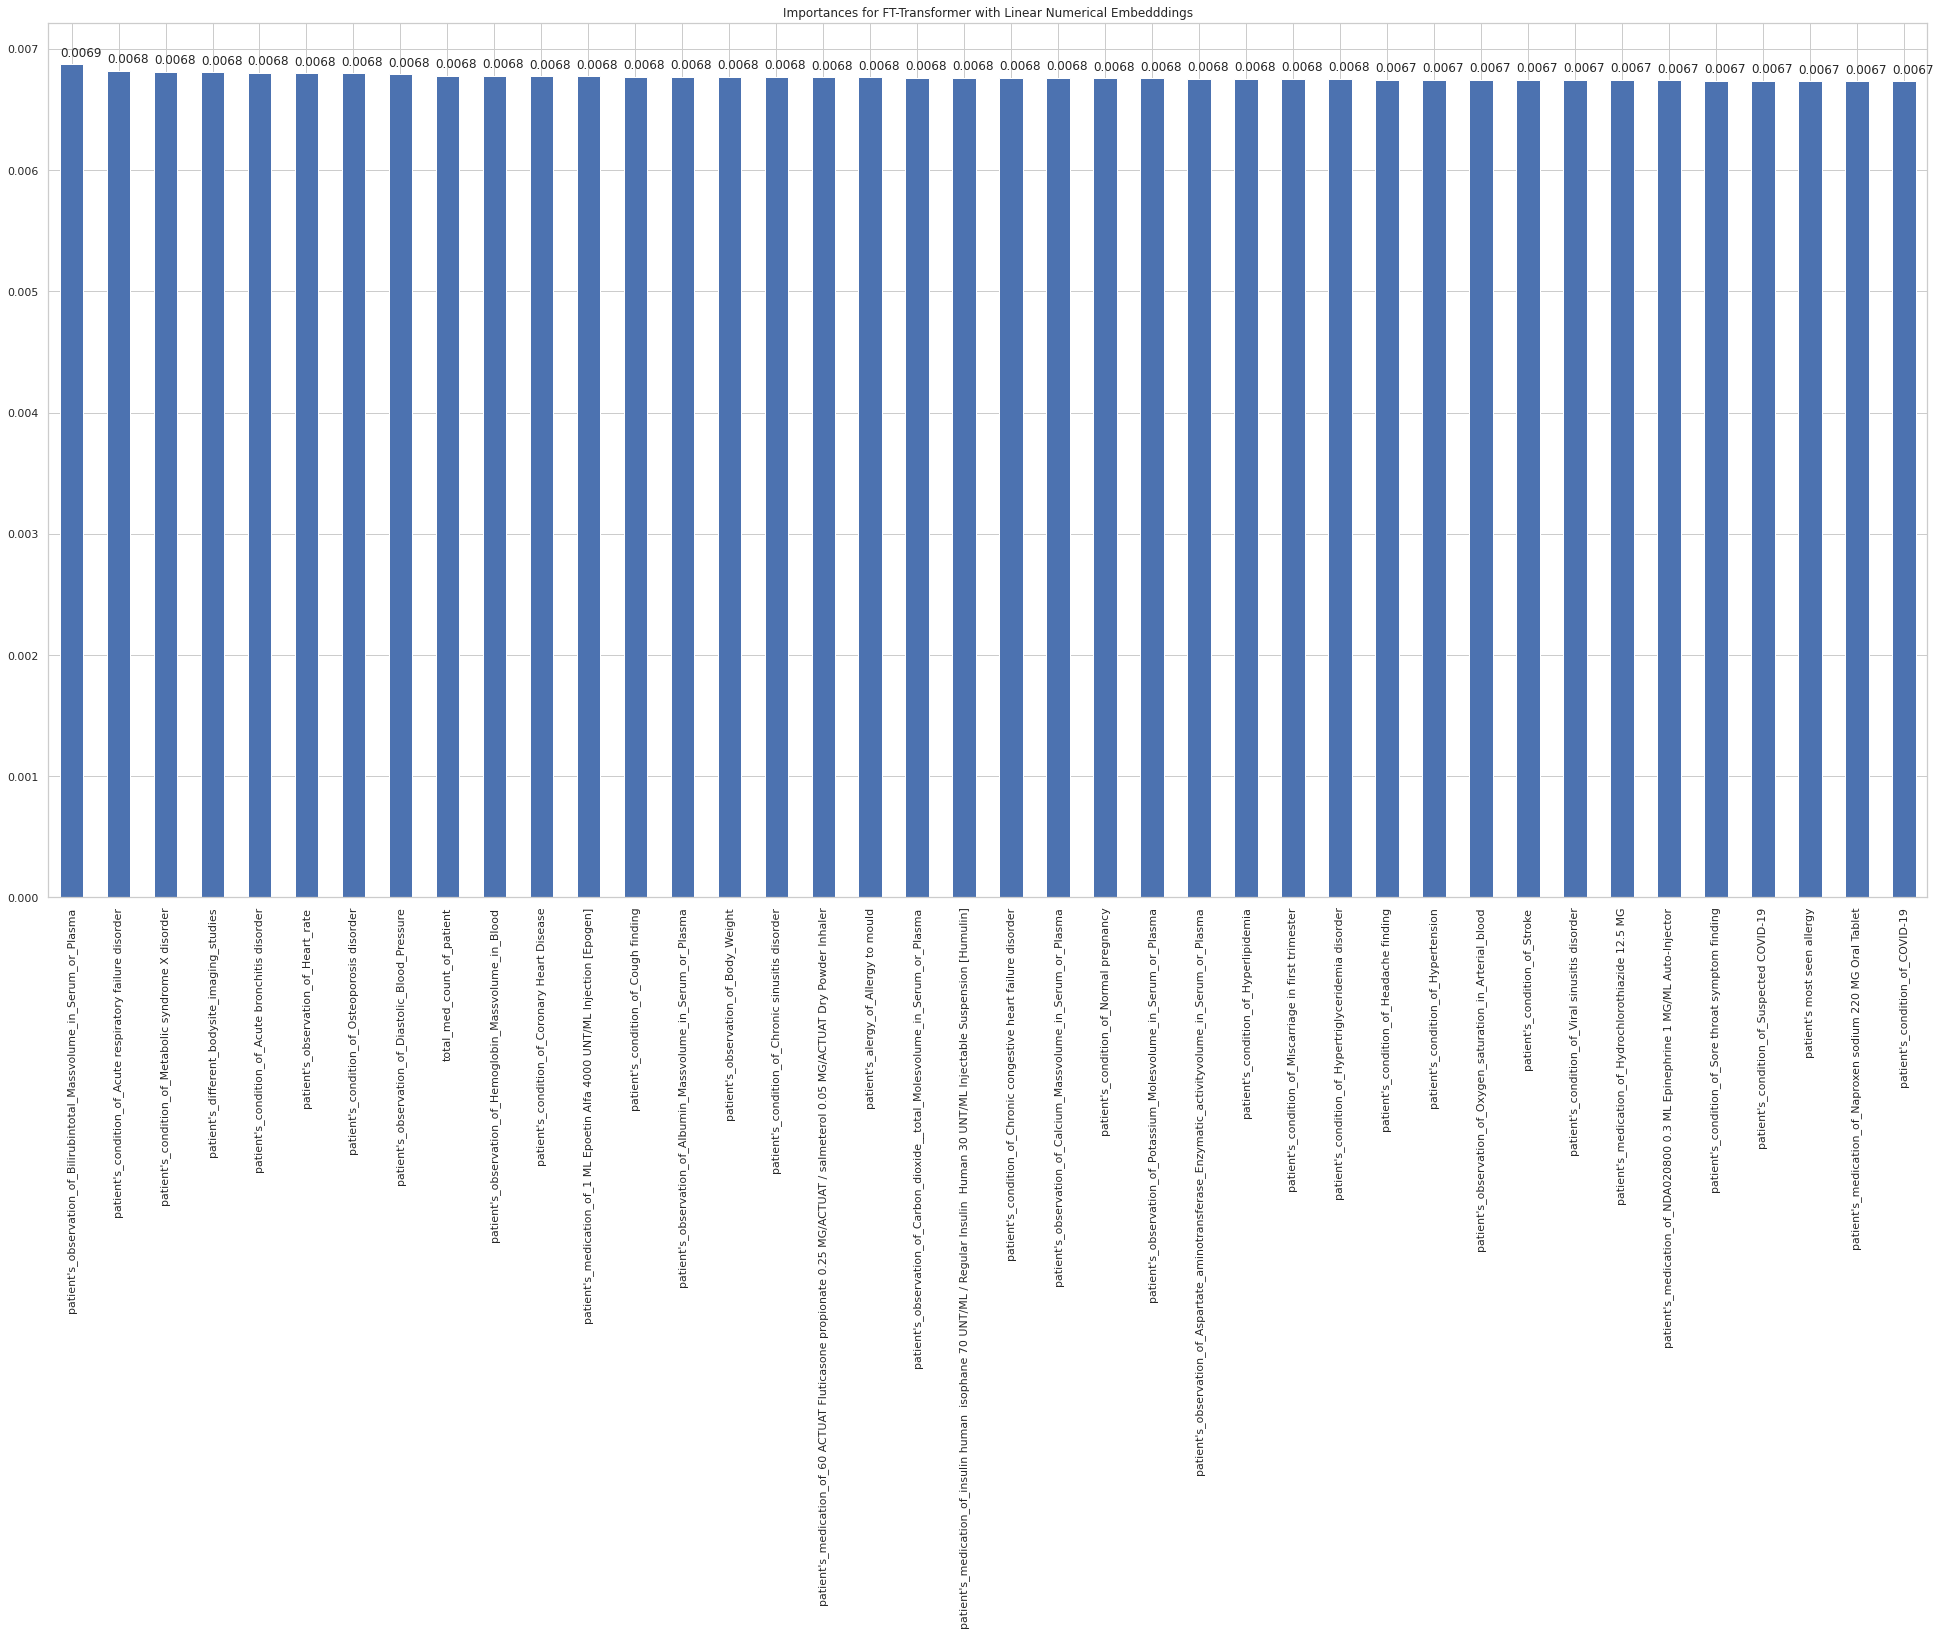

In [72]:
# Utility function
def get_model_importances(importances, title="Importances"):
    imps_sorted = importances.mean().sort_values(ascending=False)[:40]
    
    plt.figure(figsize=(30,15))
    ax = imps_sorted.plot.bar()
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height(), 4)), (p.get_x(), p.get_height() * 1.01))
    plt.title(title)
    plt.show()
    
    return imps_sorted

# Model output
linear_importances = linear_test_preds['importances']

# Exclude attention from CLS token to CLS token
linear_importances_df = pd.DataFrame(linear_importances[:, :-1], columns = FEATURES)

# Plot and store
linear_total_importances = get_model_importances(
    linear_importances_df, title="Importances for FT-Transformer with Linear Numerical Embedddings"
)

In [73]:
top40_features = linear_total_importances.index[:40]
reduced_categorical_features = []
reduced_numerical_features = []
for i in top40_features:
  if i in CATEGORICAL_FEATURES:
    reduced_categorical_features.append(i)
  else:
    reduced_numerical_features.append(i)

    

In [74]:
FEATURES = list(reduced_numerical_features) + list(reduced_categorical_features)
# Set data types
train_data[reduced_categorical_features] = train_data[reduced_categorical_features].astype(str)
test_data[reduced_categorical_features] = test_data[reduced_categorical_features].astype(str)

train_data[reduced_numerical_features] = train_data[reduced_numerical_features].astype(float)
test_data[reduced_numerical_features] = test_data[reduced_numerical_features].astype(float)

# Train/test split
X_train, X_val = train_test_split(train_data, test_size=0.2)

sc = StandardScaler()
X_train.loc[:, reduced_numerical_features] = sc.fit_transform(X_train[reduced_numerical_features])
X_val.loc[:, reduced_numerical_features] = sc.transform(X_val[reduced_numerical_features])
test_data.loc[:, reduced_numerical_features] = sc.transform(test_data[reduced_numerical_features])

train_dataset = df_to_dataset(X_train[FEATURES + [LABEL]], LABEL)
val_dataset = df_to_dataset(X_val[FEATURES + [LABEL]], LABEL, shuffle=False)  # No shuffle
test_dataset = df_to_dataset(test_data[FEATURES + [LABEL]], shuffle=False) # No target, no shuffle

In [75]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = reduced_numerical_features,
    categorical_features = reduced_categorical_features,
    numerical_data = X_train[reduced_numerical_features].values,
    categorical_data = X_train[reduced_categorical_features].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    embedding_dim=32,
    depth=4,
    heads=8,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_linear_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 15

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/15
1/1 [==============================] - 8s 8s/step - loss: 277.1582 - output_loss: 277.1582 - output_rmse: 16.6481 - val_loss: 275.3488 - val_output_loss: 275.3488 - val_output_rmse: 16.5936
Epoch 2/15
1/1 [==============================] - 0s 77ms/step - loss: 277.1582 - output_loss: 277.1582 - output_rmse: 16.6481 - val_loss: 275.3488 - val_output_loss: 275.3488 - val_output_rmse: 16.5936
Epoch 3/15
1/1 [==============================] - 0s 79ms/step - loss: 277.1582 - output_loss: 277.1582 - output_rmse: 16.6481 - val_loss: 275.3488 - val_output_loss: 275.3488 - val_output_rmse: 16.5936
Epoch 4/15
1/1 [==============================] - 0s 79ms/step - loss: 277.1582 - output_loss: 277.1582 - output_rmse: 16.6481 - val_loss: 275.3488 - val_output_loss: 275.3488 - val_output_rmse: 16.5936
Epoch 5/15
1/1 [==============================] - 0s 77ms/step - loss: 277.1582 - output_loss: 277.1582 - output_rmse: 16.6481 - val_loss: 275.3488 - val_output_loss: 275.3488 - val_output_r

In [76]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = reduced_numerical_features,
    categorical_features = reduced_categorical_features,
    numerical_data = X_train[reduced_numerical_features].values,
    categorical_data = X_train[reduced_categorical_features].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=32,
    embedding_dim=16,
    depth=3,
    heads=6,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 15

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/15
1/1 [==============================] - 7s 7s/step - loss: 276.5615 - output_loss: 276.5615 - output_rmse: 16.6301 - val_loss: 275.2465 - val_output_loss: 275.2465 - val_output_rmse: 16.5906
Epoch 2/15
1/1 [==============================] - 0s 71ms/step - loss: 274.0314 - output_loss: 274.0314 - output_rmse: 16.5539 - val_loss: 265.2102 - val_output_loss: 265.2102 - val_output_rmse: 16.2853
Epoch 3/15
1/1 [==============================] - 0s 68ms/step - loss: 270.2325 - output_loss: 270.2325 - output_rmse: 16.4388 - val_loss: 261.4082 - val_output_loss: 261.4082 - val_output_rmse: 16.1681
Epoch 4/15
1/1 [==============================] - 0s 71ms/step - loss: 268.4083 - output_loss: 268.4083 - output_rmse: 16.3832 - val_loss: 257.0106 - val_output_loss: 257.0106 - val_output_rmse: 16.0315
Epoch 5/15
1/1 [==============================] - 0s 68ms/step - loss: 264.6448 - output_loss: 264.6448 - output_rmse: 16.2679 - val_loss: 252.9285 - val_output_loss: 252.9285 - val_output_r

In [77]:
reduced_linear_test_preds = ft_linear_transformer.predict(test_dataset)
reduced_linear_rms = mean_squared_error(test_data[LABEL], reduced_linear_test_preds['output'].ravel(), squared=False)
reduced_linear_mae = mae(test_data[LABEL], reduced_linear_test_preds['output'].ravel())
reduced_linear_r2 = r2_score(test_data[LABEL], reduced_linear_test_preds['output'])

reduced_periodic_test_preds = ft_periodic_transformer.predict(test_dataset)
reduced_periodic_rms = mean_squared_error(test_data[LABEL], reduced_periodic_test_preds['output'].ravel(), squared=False)
reduced_period_mae = mae(test_data[LABEL], reduced_periodic_test_preds['output'].ravel())
reduced_periodic_r2 = r2_score(test_data[LABEL], reduced_periodic_test_preds['output'].ravel())

1/1 [==============================] - 1s 668ms/step


In [78]:
print("With all features, we got RMSE of:", linear_rms)
print("With reducing to top 40 features, we got RMSE of:", reduced_linear_rms)


With all features, we got RMSE of: 10.67038242064038
With reducing to top 40 features, we got RMSE of: 16.76840741333199


In [79]:
print("With all features, we got RMSE of:", periodic_rms)
print("With reducing to top 40 features, we got RMSE of:", reduced_periodic_rms)


With all features, we got RMSE of: 13.776594860222158
With reducing to top 40 features, we got RMSE of: 15.369411614591879


In [80]:
CATEGORICAL_FEATURES = reduced_categorical_features
NUMERIC_FEATURES = reduced_numerical_features

In [4]:
#pip install optuna

### Parameter Optimization for Transformer Models

In [82]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='periodic',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 150

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-20 00:37:27,905] A new study created in memory with name: no-name-6ebcb817-b4c7-4415-9143-fa30138300ce


Epoch 1/150
1/1 [==============================] - 5s 5s/step - loss: 252.0187 - output_loss: 252.0187 - output_rmse: 15.8751 - val_loss: 195.8907 - val_output_loss: 195.8907 - val_output_rmse: 13.9961
Epoch 2/150
1/1 [==============================] - 0s 68ms/step - loss: 200.7702 - output_loss: 200.7702 - output_rmse: 14.1693 - val_loss: 172.7775 - val_output_loss: 172.7775 - val_output_rmse: 13.1445
Epoch 3/150
1/1 [==============================] - 0s 71ms/step - loss: 177.2757 - output_loss: 177.2757 - output_rmse: 13.3145 - val_loss: 156.3115 - val_output_loss: 156.3115 - val_output_rmse: 12.5025
Epoch 4/150
1/1 [==============================] - 0s 68ms/step - loss: 161.4284 - output_loss: 161.4284 - output_rmse: 12.7054 - val_loss: 144.2650 - val_output_loss: 144.2650 - val_output_rmse: 12.0110
Epoch 5/150
1/1 [==============================] - 0s 69ms/step - loss: 149.4329 - output_loss: 149.4329 - output_rmse: 12.2243 - val_loss: 134.0925 - val_output_loss: 134.0925 - val_out

1/1 [==============================] - 1s 617ms/step


[I 2023-01-20 00:37:40,870] Trial 0 finished with value: 3.0633601015826675 and parameters: {'numerical_bins': 132, 'embedding_dim': 50, 'depth': 2, 'heads': 3, 'attn_dropout': 0.1674944402713165, 'ff_dropout': 0.05389368650595644}. Best is trial 0 with value: 3.0633601015826675.


Epoch 1/150
1/1 [==============================] - 6s 6s/step - loss: 267.8770 - output_loss: 267.8770 - output_rmse: 16.3669 - val_loss: 148.5533 - val_output_loss: 148.5533 - val_output_rmse: 12.1882
Epoch 2/150
1/1 [==============================] - 0s 75ms/step - loss: 179.7444 - output_loss: 179.7444 - output_rmse: 13.4069 - val_loss: 109.9042 - val_output_loss: 109.9042 - val_output_rmse: 10.4835
Epoch 3/150
1/1 [==============================] - 0s 73ms/step - loss: 139.2267 - output_loss: 139.2267 - output_rmse: 11.7994 - val_loss: 85.9696 - val_output_loss: 85.9696 - val_output_rmse: 9.2720
Epoch 4/150
1/1 [==============================] - 0s 75ms/step - loss: 112.7509 - output_loss: 112.7509 - output_rmse: 10.6184 - val_loss: 68.5276 - val_output_loss: 68.5276 - val_output_rmse: 8.2781
Epoch 5/150
1/1 [==============================] - 0s 79ms/step - loss: 93.5798 - output_loss: 93.5798 - output_rmse: 9.6737 - val_loss: 56.3484 - val_output_loss: 56.3484 - val_output_rmse: 7

1/1 [==============================] - 1s 602ms/step


[I 2023-01-20 00:37:50,914] Trial 1 finished with value: 3.061822979387704 and parameters: {'numerical_bins': 135, 'embedding_dim': 100, 'depth': 2, 'heads': 2, 'attn_dropout': 0.21860116764348725, 'ff_dropout': 0.34299045715723175}. Best is trial 1 with value: 3.061822979387704.


Epoch 1/150
1/1 [==============================] - 4s 4s/step - loss: 276.8913 - output_loss: 276.8913 - output_rmse: 16.6401 - val_loss: 225.8530 - val_output_loss: 225.8530 - val_output_rmse: 15.0284
Epoch 2/150
1/1 [==============================] - 0s 67ms/step - loss: 245.2530 - output_loss: 245.2530 - output_rmse: 15.6606 - val_loss: 182.2511 - val_output_loss: 182.2511 - val_output_rmse: 13.5000
Epoch 3/150
1/1 [==============================] - 0s 62ms/step - loss: 201.2352 - output_loss: 201.2352 - output_rmse: 14.1857 - val_loss: 165.7775 - val_output_loss: 165.7775 - val_output_rmse: 12.8755
Epoch 4/150
1/1 [==============================] - 0s 62ms/step - loss: 180.6437 - output_loss: 180.6437 - output_rmse: 13.4404 - val_loss: 155.2626 - val_output_loss: 155.2626 - val_output_rmse: 12.4604
Epoch 5/150
1/1 [==============================] - 0s 62ms/step - loss: 167.7425 - output_loss: 167.7425 - output_rmse: 12.9515 - val_loss: 147.0896 - val_output_loss: 147.0896 - val_out

[I 2023-01-20 00:38:02,982] Trial 2 finished with value: 3.0733487512983504 and parameters: {'numerical_bins': 100, 'embedding_dim': 50, 'depth': 1, 'heads': 5, 'attn_dropout': 0.4428859243442776, 'ff_dropout': 0.14104660266506192}. Best is trial 1 with value: 3.061822979387704.


Epoch 1/150
1/1 [==============================] - 5s 5s/step - loss: 275.5623 - output_loss: 275.5623 - output_rmse: 16.6001 - val_loss: 170.2654 - val_output_loss: 170.2654 - val_output_rmse: 13.0486
Epoch 2/150
1/1 [==============================] - 0s 86ms/step - loss: 176.1406 - output_loss: 176.1406 - output_rmse: 13.2718 - val_loss: 118.5199 - val_output_loss: 118.5199 - val_output_rmse: 10.8867
Epoch 3/150
1/1 [==============================] - 0s 85ms/step - loss: 124.6135 - output_loss: 124.6135 - output_rmse: 11.1630 - val_loss: 89.6924 - val_output_loss: 89.6924 - val_output_rmse: 9.4706
Epoch 4/150
1/1 [==============================] - 0s 87ms/step - loss: 96.4395 - output_loss: 96.4395 - output_rmse: 9.8204 - val_loss: 72.5003 - val_output_loss: 72.5003 - val_output_rmse: 8.5147
Epoch 5/150
1/1 [==============================] - 0s 87ms/step - loss: 79.1833 - output_loss: 79.1833 - output_rmse: 8.8985 - val_loss: 60.2670 - val_output_loss: 60.2670 - val_output_rmse: 7.76

[I 2023-01-20 00:38:18,145] Trial 3 finished with value: 3.059859910090364 and parameters: {'numerical_bins': 148, 'embedding_dim': 99, 'depth': 2, 'heads': 5, 'attn_dropout': 0.13945248614625727, 'ff_dropout': 0.07483178914988031}. Best is trial 3 with value: 3.059859910090364.


Epoch 1/150
1/1 [==============================] - 8s 8s/step - loss: 271.8642 - output_loss: 271.8642 - output_rmse: 16.4883 - val_loss: 211.5336 - val_output_loss: 211.5336 - val_output_rmse: 14.5442
Epoch 2/150
1/1 [==============================] - 0s 100ms/step - loss: 236.8046 - output_loss: 236.8046 - output_rmse: 15.3885 - val_loss: 188.7252 - val_output_loss: 188.7252 - val_output_rmse: 13.7377
Epoch 3/150
1/1 [==============================] - 0s 100ms/step - loss: 208.7317 - output_loss: 208.7317 - output_rmse: 14.4476 - val_loss: 169.9274 - val_output_loss: 169.9274 - val_output_rmse: 13.0356
Epoch 4/150
1/1 [==============================] - 0s 99ms/step - loss: 191.5498 - output_loss: 191.5498 - output_rmse: 13.8401 - val_loss: 157.8112 - val_output_loss: 157.8112 - val_output_rmse: 12.5623
Epoch 5/150
1/1 [==============================] - 0s 99ms/step - loss: 177.9854 - output_loss: 177.9854 - output_rmse: 13.3411 - val_loss: 148.1403 - val_output_loss: 148.1403 - val_o

[I 2023-01-20 00:38:43,865] Trial 4 finished with value: 3.0596906066619836 and parameters: {'numerical_bins': 183, 'embedding_dim': 36, 'depth': 4, 'heads': 8, 'attn_dropout': 0.2830214880262497, 'ff_dropout': 0.23507438167240147}. Best is trial 4 with value: 3.0596906066619836.


Epoch 1/150
1/1 [==============================] - 7s 7s/step - loss: 257.5217 - output_loss: 257.5217 - output_rmse: 16.0475 - val_loss: 175.4032 - val_output_loss: 175.4032 - val_output_rmse: 13.2440
Epoch 2/150
1/1 [==============================] - 0s 79ms/step - loss: 213.7146 - output_loss: 213.7146 - output_rmse: 14.6190 - val_loss: 164.4111 - val_output_loss: 164.4111 - val_output_rmse: 12.8223
Epoch 3/150
1/1 [==============================] - 0s 77ms/step - loss: 193.2476 - output_loss: 193.2476 - output_rmse: 13.9014 - val_loss: 158.7785 - val_output_loss: 158.7785 - val_output_rmse: 12.6007
Epoch 4/150
1/1 [==============================] - 0s 82ms/step - loss: 179.4026 - output_loss: 179.4026 - output_rmse: 13.3941 - val_loss: 151.8303 - val_output_loss: 151.8303 - val_output_rmse: 12.3219
Epoch 5/150
1/1 [==============================] - 0s 80ms/step - loss: 169.9694 - output_loss: 169.9694 - output_rmse: 13.0372 - val_loss: 141.0105 - val_output_loss: 141.0105 - val_out

[I 2023-01-20 00:39:04,792] Trial 5 finished with value: 3.058512111906106 and parameters: {'numerical_bins': 110, 'embedding_dim': 34, 'depth': 3, 'heads': 3, 'attn_dropout': 0.34962321830992577, 'ff_dropout': 0.23645441069857537}. Best is trial 5 with value: 3.058512111906106.


Epoch 1/150
1/1 [==============================] - 11s 11s/step - loss: 274.9437 - output_loss: 274.9437 - output_rmse: 16.5814 - val_loss: 273.7309 - val_output_loss: 273.7309 - val_output_rmse: 16.5448
Epoch 2/150
1/1 [==============================] - 0s 98ms/step - loss: 272.9933 - output_loss: 272.9933 - output_rmse: 16.5225 - val_loss: 269.3238 - val_output_loss: 269.3238 - val_output_rmse: 16.4111
Epoch 3/150
1/1 [==============================] - 0s 102ms/step - loss: 269.4140 - output_loss: 269.4140 - output_rmse: 16.4138 - val_loss: 262.1495 - val_output_loss: 262.1495 - val_output_rmse: 16.1910
Epoch 4/150
1/1 [==============================] - 0s 100ms/step - loss: 265.1740 - output_loss: 265.1740 - output_rmse: 16.2842 - val_loss: 253.2278 - val_output_loss: 253.2278 - val_output_rmse: 15.9131
Epoch 5/150
1/1 [==============================] - 0s 99ms/step - loss: 259.0718 - output_loss: 259.0718 - output_rmse: 16.0957 - val_loss: 241.3201 - val_output_loss: 241.3201 - val

[I 2023-01-20 00:39:33,533] Trial 6 finished with value: 4.788251497316168 and parameters: {'numerical_bins': 161, 'embedding_dim': 12, 'depth': 6, 'heads': 4, 'attn_dropout': 0.1440214202207485, 'ff_dropout': 0.31598667954061355}. Best is trial 5 with value: 3.058512111906106.


Epoch 1/150
1/1 [==============================] - 7s 7s/step - loss: 260.2136 - output_loss: 260.2136 - output_rmse: 16.1311 - val_loss: 209.1095 - val_output_loss: 209.1095 - val_output_rmse: 14.4606
Epoch 2/150
1/1 [==============================] - 0s 79ms/step - loss: 212.4108 - output_loss: 212.4108 - output_rmse: 14.5743 - val_loss: 184.6105 - val_output_loss: 184.6105 - val_output_rmse: 13.5871
Epoch 3/150
1/1 [==============================] - 0s 82ms/step - loss: 189.0681 - output_loss: 189.0681 - output_rmse: 13.7502 - val_loss: 165.6530 - val_output_loss: 165.6530 - val_output_rmse: 12.8706
Epoch 4/150
1/1 [==============================] - 0s 79ms/step - loss: 170.4605 - output_loss: 170.4605 - output_rmse: 13.0561 - val_loss: 151.2058 - val_output_loss: 151.2058 - val_output_rmse: 12.2966
Epoch 5/150
1/1 [==============================] - 0s 80ms/step - loss: 155.6041 - output_loss: 155.6041 - output_rmse: 12.4741 - val_loss: 140.4235 - val_output_loss: 140.4235 - val_out

[I 2023-01-20 00:39:51,891] Trial 7 finished with value: 3.0636422909926675 and parameters: {'numerical_bins': 101, 'embedding_dim': 45, 'depth': 3, 'heads': 3, 'attn_dropout': 0.3897718616753106, 'ff_dropout': 0.0026466319197876453}. Best is trial 5 with value: 3.058512111906106.


Epoch 1/150
1/1 [==============================] - 8s 8s/step - loss: 218.9228 - output_loss: 218.9228 - output_rmse: 14.7960 - val_loss: 190.4506 - val_output_loss: 190.4506 - val_output_rmse: 13.8004
Epoch 2/150
1/1 [==============================] - 0s 86ms/step - loss: 207.7278 - output_loss: 207.7278 - output_rmse: 14.4128 - val_loss: 182.2216 - val_output_loss: 182.2216 - val_output_rmse: 13.4989
Epoch 3/150
1/1 [==============================] - 0s 88ms/step - loss: 202.0727 - output_loss: 202.0727 - output_rmse: 14.2152 - val_loss: 178.8091 - val_output_loss: 178.8091 - val_output_rmse: 13.3720
Epoch 4/150
1/1 [==============================] - 0s 86ms/step - loss: 195.5223 - output_loss: 195.5223 - output_rmse: 13.9829 - val_loss: 176.5306 - val_output_loss: 176.5306 - val_output_rmse: 13.2865
Epoch 5/150
1/1 [==============================] - 0s 88ms/step - loss: 190.6208 - output_loss: 190.6208 - output_rmse: 13.8066 - val_loss: 174.4003 - val_output_loss: 174.4003 - val_out

[I 2023-01-20 00:40:15,801] Trial 8 finished with value: 3.113171239847098 and parameters: {'numerical_bins': 185, 'embedding_dim': 13, 'depth': 4, 'heads': 7, 'attn_dropout': 0.247629162226571, 'ff_dropout': 0.2957518232484911}. Best is trial 5 with value: 3.058512111906106.


Epoch 1/150
1/1 [==============================] - 4s 4s/step - loss: 214.2155 - output_loss: 214.2155 - output_rmse: 14.6361 - val_loss: 164.4631 - val_output_loss: 164.4631 - val_output_rmse: 12.8243
Epoch 2/150
1/1 [==============================] - 0s 64ms/step - loss: 173.0884 - output_loss: 173.0884 - output_rmse: 13.1563 - val_loss: 146.7849 - val_output_loss: 146.7849 - val_output_rmse: 12.1155
Epoch 3/150
1/1 [==============================] - 0s 62ms/step - loss: 154.8958 - output_loss: 154.8958 - output_rmse: 12.4457 - val_loss: 129.2671 - val_output_loss: 129.2671 - val_output_rmse: 11.3696
Epoch 4/150
1/1 [==============================] - 0s 64ms/step - loss: 138.6917 - output_loss: 138.6917 - output_rmse: 11.7767 - val_loss: 117.4858 - val_output_loss: 117.4858 - val_output_rmse: 10.8391
Epoch 5/150
1/1 [==============================] - 0s 64ms/step - loss: 129.3365 - output_loss: 129.3365 - output_rmse: 11.3726 - val_loss: 111.9536 - val_output_loss: 111.9536 - val_out

[I 2023-01-20 00:40:28,665] Trial 9 finished with value: 3.0672729613209935 and parameters: {'numerical_bins': 187, 'embedding_dim': 41, 'depth': 1, 'heads': 8, 'attn_dropout': 0.07712202967918874, 'ff_dropout': 0.11441046506171781}. Best is trial 5 with value: 3.058512111906106.


Number of finished trials: 10
Best trial: {'numerical_bins': 110, 'embedding_dim': 34, 'depth': 3, 'heads': 3, 'attn_dropout': 0.34962321830992577, 'ff_dropout': 0.23645441069857537}


In [83]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=160,
    embedding_dim=16,
    depth=1,
    heads=8,
    attn_dropout= 0.05918486635135395,
    ff_dropout= 0.14970556687291225,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_encoder_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 250

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/250
1/1 [==============================] - 4s 4s/step - loss: 264.0879 - output_loss: 264.0879 - output_rmse: 16.2508 - val_loss: 248.8911 - val_output_loss: 248.8911 - val_output_rmse: 15.7763
Epoch 2/250
1/1 [==============================] - 0s 60ms/step - loss: 248.7643 - output_loss: 248.7643 - output_rmse: 15.7723 - val_loss: 231.5591 - val_output_loss: 231.5591 - val_output_rmse: 15.2171
Epoch 3/250
1/1 [==============================] - 0s 60ms/step - loss: 234.3488 - output_loss: 234.3488 - output_rmse: 15.3085 - val_loss: 219.8279 - val_output_loss: 219.8279 - val_output_rmse: 14.8266
Epoch 4/250
1/1 [==============================] - 0s 64ms/step - loss: 223.8910 - output_loss: 223.8910 - output_rmse: 14.9630 - val_loss: 209.9446 - val_output_loss: 209.9446 - val_output_rmse: 14.4895
Epoch 5/250
1/1 [==============================] - 0s 61ms/step - loss: 215.1832 - output_loss: 215.1832 - output_rmse: 14.6691 - val_loss: 201.6158 - val_output_loss: 201.6158 - val_out

In [93]:
periodic_tuned_test_preds = ft_periodic_encoder_transformer.predict(test_dataset)
periodic_tuned_rms = mean_squared_error(test_data[LABEL], periodic_tuned_test_preds['output'].ravel(), squared=False)
periodic_tuned_mae = mae(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())
periodic_tuned_r2 = r2_score(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())


1/1 [==============================] - 0s 16ms/step


### Periodic Encoding FT Transformer Model Graphs

In [86]:
df["start_month"] = df.icu_start.dt.month
df["start_week"] = df.icu_start.dt.week
df["start_day"] = df.icu_start.dt.dayofyear

test["start_month"] = test.icu_start.dt.month
test["start_week"] = test.icu_start.dt.week
test["start_day"] = test.icu_start.dt.dayofyear

Text(0, 0.5, '% difference between real values and predictions ( Periodic Encoding FT )')

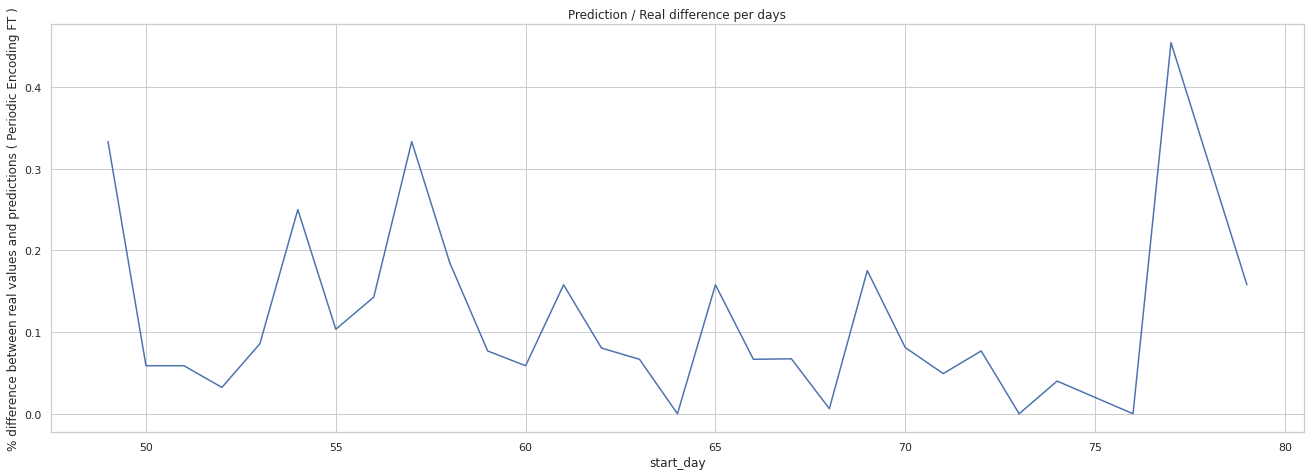

In [87]:
test_copy = df.loc[(df.dataset == "test") & (df.duration.notnull())].copy()
test_copy["preds"] = periodic_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Periodic Encoding FT )")

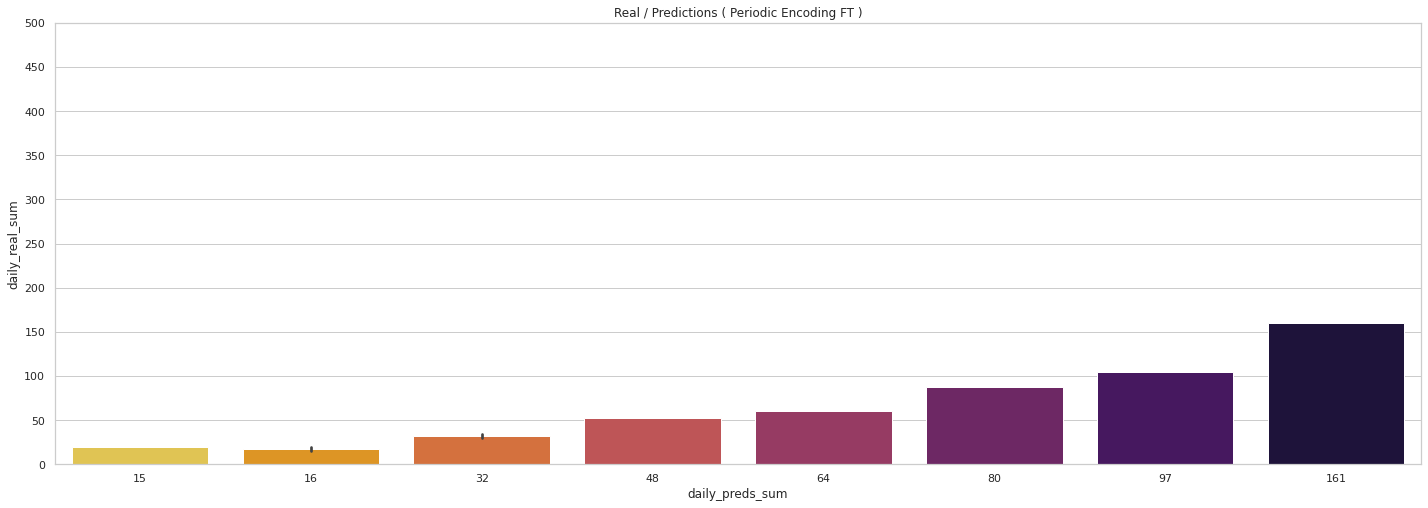

In [88]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Periodic Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Periodic Encoding FT )')

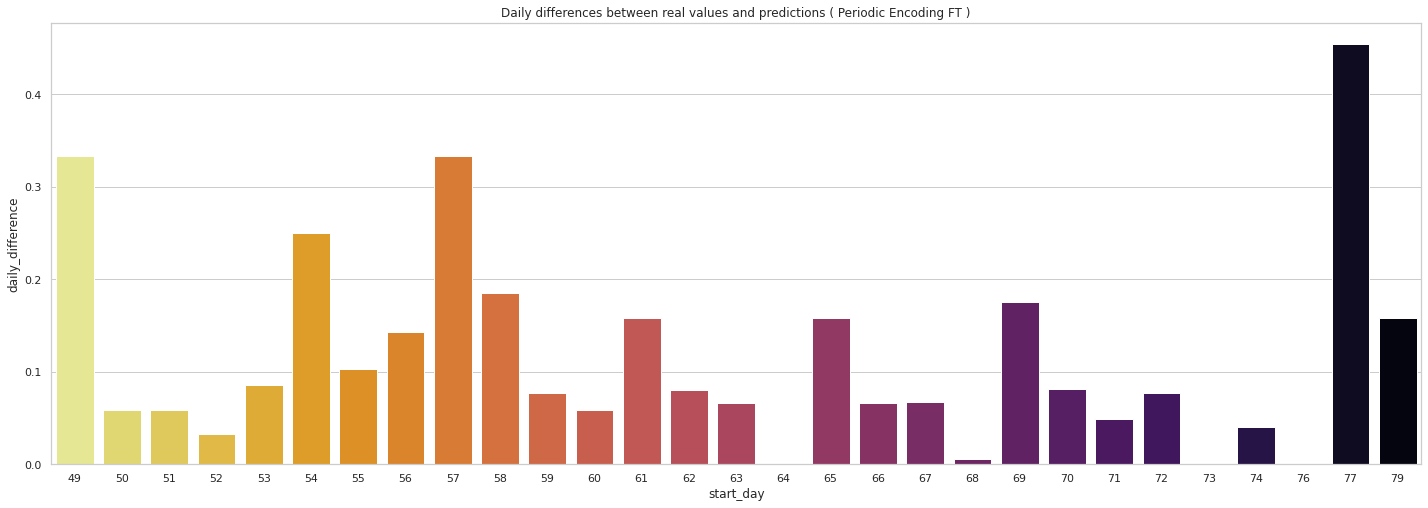

In [89]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Periodic Encoding FT )")

### Linear Encoding Parameter Optimization

In [97]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='linear',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 150

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-20 00:52:54,885] A new study created in memory with name: no-name-acbe565b-c517-42df-a078-d6c4784da59f


Epoch 1/150
1/1 [==============================] - 11s 11s/step - loss: 272.3015 - output_loss: 272.3015 - output_rmse: 16.5016 - val_loss: 262.7818 - val_output_loss: 262.7818 - val_output_rmse: 16.2105
Epoch 2/150
1/1 [==============================] - 0s 107ms/step - loss: 258.1372 - output_loss: 258.1372 - output_rmse: 16.0666 - val_loss: 214.4913 - val_output_loss: 214.4913 - val_output_rmse: 14.6455
Epoch 3/150
1/1 [==============================] - 0s 108ms/step - loss: 237.6780 - output_loss: 237.6780 - output_rmse: 15.4168 - val_loss: 180.2978 - val_output_loss: 180.2978 - val_output_rmse: 13.4275
Epoch 4/150
1/1 [==============================] - 0s 113ms/step - loss: 215.9358 - output_loss: 215.9358 - output_rmse: 14.6948 - val_loss: 159.0751 - val_output_loss: 159.0751 - val_output_rmse: 12.6125
Epoch 5/150
1/1 [==============================] - 0s 106ms/step - loss: 196.4608 - output_loss: 196.4608 - output_rmse: 14.0164 - val_loss: 145.3839 - val_output_loss: 145.3839 - v

[I 2023-01-20 00:53:23,895] Trial 0 finished with value: 3.0603538862584805 and parameters: {'numerical_bins': 105, 'embedding_dim': 23, 'depth': 6, 'heads': 4, 'attn_dropout': 0.3627244782519825, 'ff_dropout': 0.3925284647860158}. Best is trial 0 with value: 3.0603538862584805.


Epoch 1/150
1/1 [==============================] - 4s 4s/step - loss: 273.2955 - output_loss: 273.2955 - output_rmse: 16.5317 - val_loss: 209.0099 - val_output_loss: 209.0099 - val_output_rmse: 14.4572
Epoch 2/150
1/1 [==============================] - 0s 63ms/step - loss: 212.9964 - output_loss: 212.9964 - output_rmse: 14.5944 - val_loss: 171.5330 - val_output_loss: 171.5330 - val_output_rmse: 13.0971
Epoch 3/150
1/1 [==============================] - 0s 63ms/step - loss: 177.5932 - output_loss: 177.5932 - output_rmse: 13.3264 - val_loss: 158.4896 - val_output_loss: 158.4896 - val_output_rmse: 12.5893
Epoch 4/150
1/1 [==============================] - 0s 63ms/step - loss: 163.4030 - output_loss: 163.4030 - output_rmse: 12.7829 - val_loss: 150.8922 - val_output_loss: 150.8922 - val_output_rmse: 12.2838
Epoch 5/150
1/1 [==============================] - 0s 65ms/step - loss: 154.7502 - output_loss: 154.7502 - output_rmse: 12.4399 - val_loss: 144.0263 - val_output_loss: 144.0263 - val_out

[I 2023-01-20 00:53:37,018] Trial 1 finished with value: 3.0607891402043457 and parameters: {'numerical_bins': 200, 'embedding_dim': 38, 'depth': 1, 'heads': 3, 'attn_dropout': 0.19452171724696093, 'ff_dropout': 0.021574660215171404}. Best is trial 0 with value: 3.0603538862584805.


Epoch 1/150
1/1 [==============================] - 11s 11s/step - loss: 271.0082 - output_loss: 271.0082 - output_rmse: 16.4623 - val_loss: 177.4284 - val_output_loss: 177.4284 - val_output_rmse: 13.3202
Epoch 2/150
1/1 [==============================] - 0s 128ms/step - loss: 208.7974 - output_loss: 208.7974 - output_rmse: 14.4498 - val_loss: 142.2481 - val_output_loss: 142.2481 - val_output_rmse: 11.9268
Epoch 3/150
1/1 [==============================] - 0s 128ms/step - loss: 163.4669 - output_loss: 163.4669 - output_rmse: 12.7854 - val_loss: 125.1427 - val_output_loss: 125.1427 - val_output_rmse: 11.1867
Epoch 4/150
1/1 [==============================] - 0s 128ms/step - loss: 141.8892 - output_loss: 141.8892 - output_rmse: 11.9117 - val_loss: 115.0529 - val_output_loss: 115.0529 - val_output_rmse: 10.7263
Epoch 5/150
1/1 [==============================] - 0s 130ms/step - loss: 127.8147 - output_loss: 127.8147 - output_rmse: 11.3055 - val_loss: 107.6384 - val_output_loss: 107.6384 - v

[I 2023-01-20 00:54:03,564] Trial 2 finished with value: 3.059491708921651 and parameters: {'numerical_bins': 77, 'embedding_dim': 53, 'depth': 6, 'heads': 4, 'attn_dropout': 0.4214903853113452, 'ff_dropout': 0.2607233397970245}. Best is trial 2 with value: 3.059491708921651.


Epoch 1/150
1/1 [==============================] - 8s 8s/step - loss: 272.5368 - output_loss: 272.5368 - output_rmse: 16.5087 - val_loss: 227.4721 - val_output_loss: 227.4721 - val_output_rmse: 15.0822
Epoch 2/150
1/1 [==============================] - 0s 101ms/step - loss: 237.3716 - output_loss: 237.3716 - output_rmse: 15.4069 - val_loss: 196.8527 - val_output_loss: 196.8527 - val_output_rmse: 14.0304
Epoch 3/150
1/1 [==============================] - 0s 101ms/step - loss: 206.1573 - output_loss: 206.1573 - output_rmse: 14.3582 - val_loss: 180.8000 - val_output_loss: 180.8000 - val_output_rmse: 13.4462
Epoch 4/150
1/1 [==============================] - 0s 101ms/step - loss: 189.1189 - output_loss: 189.1189 - output_rmse: 13.7521 - val_loss: 171.0464 - val_output_loss: 171.0464 - val_output_rmse: 13.0785
Epoch 5/150
1/1 [==============================] - 0s 104ms/step - loss: 179.1258 - output_loss: 179.1258 - output_rmse: 13.3838 - val_loss: 161.7724 - val_output_loss: 161.7724 - val

[I 2023-01-20 00:54:29,471] Trial 3 finished with value: 3.0582441542649876 and parameters: {'numerical_bins': 166, 'embedding_dim': 39, 'depth': 4, 'heads': 6, 'attn_dropout': 0.38521870058327434, 'ff_dropout': 0.06051922059322673}. Best is trial 3 with value: 3.0582441542649876.


Epoch 1/150
1/1 [==============================] - 4s 4s/step - loss: 275.8040 - output_loss: 275.8040 - output_rmse: 16.6073 - val_loss: 184.9973 - val_output_loss: 184.9973 - val_output_rmse: 13.6014
Epoch 2/150
1/1 [==============================] - 0s 71ms/step - loss: 194.8737 - output_loss: 194.8737 - output_rmse: 13.9597 - val_loss: 144.7783 - val_output_loss: 144.7783 - val_output_rmse: 12.0324
Epoch 3/150
1/1 [==============================] - 0s 71ms/step - loss: 157.5858 - output_loss: 157.5858 - output_rmse: 12.5533 - val_loss: 117.7041 - val_output_loss: 117.7041 - val_output_rmse: 10.8492
Epoch 4/150
1/1 [==============================] - 0s 73ms/step - loss: 133.2627 - output_loss: 133.2627 - output_rmse: 11.5439 - val_loss: 99.7895 - val_output_loss: 99.7895 - val_output_rmse: 9.9895
Epoch 5/150
1/1 [==============================] - 0s 76ms/step - loss: 114.2925 - output_loss: 114.2925 - output_rmse: 10.6908 - val_loss: 86.5768 - val_output_loss: 86.5768 - val_output_r

[I 2023-01-20 00:54:38,970] Trial 4 finished with value: 3.0615909382966193 and parameters: {'numerical_bins': 105, 'embedding_dim': 85, 'depth': 1, 'heads': 8, 'attn_dropout': 0.12275907639464151, 'ff_dropout': 0.16080569175131398}. Best is trial 3 with value: 3.0582441542649876.


Epoch 1/150
1/1 [==============================] - 8s 8s/step - loss: 261.4552 - output_loss: 261.4552 - output_rmse: 16.1696 - val_loss: 134.8409 - val_output_loss: 134.8409 - val_output_rmse: 11.6121
Epoch 2/150
1/1 [==============================] - 0s 96ms/step - loss: 139.2756 - output_loss: 139.2756 - output_rmse: 11.8015 - val_loss: 93.8894 - val_output_loss: 93.8894 - val_output_rmse: 9.6897
Epoch 3/150
1/1 [==============================] - 0s 97ms/step - loss: 97.3983 - output_loss: 97.3983 - output_rmse: 9.8691 - val_loss: 60.1803 - val_output_loss: 60.1803 - val_output_rmse: 7.7576
Epoch 4/150
1/1 [==============================] - 0s 97ms/step - loss: 63.4827 - output_loss: 63.4827 - output_rmse: 7.9676 - val_loss: 39.4216 - val_output_loss: 39.4216 - val_output_rmse: 6.2787
Epoch 5/150
1/1 [==============================] - 0s 98ms/step - loss: 42.5475 - output_loss: 42.5475 - output_rmse: 6.5228 - val_loss: 28.4561 - val_output_loss: 28.4561 - val_output_rmse: 5.3344
Epo

[I 2023-01-20 00:54:53,500] Trial 5 finished with value: 3.061221976653445 and parameters: {'numerical_bins': 192, 'embedding_dim': 61, 'depth': 4, 'heads': 4, 'attn_dropout': 0.04129007699788867, 'ff_dropout': 0.03198646647241232}. Best is trial 3 with value: 3.0582441542649876.


Epoch 1/150
1/1 [==============================] - 8s 8s/step - loss: 257.8730 - output_loss: 257.8730 - output_rmse: 16.0584 - val_loss: 147.7968 - val_output_loss: 147.7968 - val_output_rmse: 12.1572
Epoch 2/150
1/1 [==============================] - 0s 107ms/step - loss: 167.0126 - output_loss: 167.0126 - output_rmse: 12.9233 - val_loss: 108.2351 - val_output_loss: 108.2351 - val_output_rmse: 10.4036
Epoch 3/150
1/1 [==============================] - 0s 110ms/step - loss: 125.5682 - output_loss: 125.5682 - output_rmse: 11.2057 - val_loss: 95.4569 - val_output_loss: 95.4569 - val_output_rmse: 9.7702
Epoch 4/150
1/1 [==============================] - 0s 103ms/step - loss: 108.6715 - output_loss: 108.6715 - output_rmse: 10.4246 - val_loss: 84.8213 - val_output_loss: 84.8213 - val_output_rmse: 9.2098
Epoch 5/150
1/1 [==============================] - 0s 109ms/step - loss: 96.5748 - output_loss: 96.5748 - output_rmse: 9.8272 - val_loss: 77.2290 - val_output_loss: 77.2290 - val_output_rms

[I 2023-01-20 00:55:14,524] Trial 6 finished with value: 3.061264676650787 and parameters: {'numerical_bins': 94, 'embedding_dim': 46, 'depth': 4, 'heads': 8, 'attn_dropout': 0.42830805688259227, 'ff_dropout': 0.22815965687254053}. Best is trial 3 with value: 3.0582441542649876.


Epoch 1/150
1/1 [==============================] - 7s 7s/step - loss: 273.9711 - output_loss: 273.9711 - output_rmse: 16.5521 - val_loss: 249.8370 - val_output_loss: 249.8370 - val_output_rmse: 15.8062
Epoch 2/150
1/1 [==============================] - 0s 86ms/step - loss: 257.8749 - output_loss: 257.8749 - output_rmse: 16.0585 - val_loss: 220.3023 - val_output_loss: 220.3023 - val_output_rmse: 14.8426
Epoch 3/150
1/1 [==============================] - 0s 89ms/step - loss: 245.0391 - output_loss: 245.0391 - output_rmse: 15.6537 - val_loss: 201.1266 - val_output_loss: 201.1266 - val_output_rmse: 14.1819
Epoch 4/150
1/1 [==============================] - 0s 85ms/step - loss: 227.2391 - output_loss: 227.2391 - output_rmse: 15.0745 - val_loss: 189.7153 - val_output_loss: 189.7153 - val_output_rmse: 13.7737
Epoch 5/150
1/1 [==============================] - 0s 85ms/step - loss: 213.7243 - output_loss: 213.7243 - output_rmse: 14.6193 - val_loss: 180.5474 - val_output_loss: 180.5474 - val_out

[I 2023-01-20 00:55:37,504] Trial 7 finished with value: 3.0872234650349752 and parameters: {'numerical_bins': 87, 'embedding_dim': 30, 'depth': 3, 'heads': 7, 'attn_dropout': 0.23145801373082758, 'ff_dropout': 0.43167496768470165}. Best is trial 3 with value: 3.0582441542649876.


Epoch 1/150
1/1 [==============================] - 4s 4s/step - loss: 248.1449 - output_loss: 248.1449 - output_rmse: 15.7526 - val_loss: 192.1707 - val_output_loss: 192.1707 - val_output_rmse: 13.8626
Epoch 2/150
1/1 [==============================] - 0s 63ms/step - loss: 211.5092 - output_loss: 211.5092 - output_rmse: 14.5434 - val_loss: 167.8222 - val_output_loss: 167.8222 - val_output_rmse: 12.9546
Epoch 3/150
1/1 [==============================] - 0s 62ms/step - loss: 191.5219 - output_loss: 191.5219 - output_rmse: 13.8391 - val_loss: 157.1084 - val_output_loss: 157.1084 - val_output_rmse: 12.5343
Epoch 4/150
1/1 [==============================] - 0s 65ms/step - loss: 178.1228 - output_loss: 178.1228 - output_rmse: 13.3463 - val_loss: 146.6525 - val_output_loss: 146.6525 - val_output_rmse: 12.1100
Epoch 5/150
1/1 [==============================] - 0s 65ms/step - loss: 167.0641 - output_loss: 167.0641 - output_rmse: 12.9253 - val_loss: 137.4356 - val_output_loss: 137.4356 - val_out

[I 2023-01-20 00:55:49,991] Trial 8 finished with value: 3.0592067303073343 and parameters: {'numerical_bins': 112, 'embedding_dim': 39, 'depth': 1, 'heads': 4, 'attn_dropout': 0.4684178233692039, 'ff_dropout': 0.3174347710465402}. Best is trial 3 with value: 3.0582441542649876.


Epoch 1/150
1/1 [==============================] - 4s 4s/step - loss: 275.7344 - output_loss: 275.7344 - output_rmse: 16.6053 - val_loss: 223.3840 - val_output_loss: 223.3840 - val_output_rmse: 14.9460
Epoch 2/150
1/1 [==============================] - 0s 65ms/step - loss: 233.2469 - output_loss: 233.2469 - output_rmse: 15.2724 - val_loss: 206.4837 - val_output_loss: 206.4837 - val_output_rmse: 14.3695
Epoch 3/150
1/1 [==============================] - 0s 70ms/step - loss: 212.8437 - output_loss: 212.8437 - output_rmse: 14.5892 - val_loss: 192.6701 - val_output_loss: 192.6701 - val_output_rmse: 13.8806
Epoch 4/150
1/1 [==============================] - 0s 68ms/step - loss: 199.4625 - output_loss: 199.4625 - output_rmse: 14.1231 - val_loss: 181.7438 - val_output_loss: 181.7438 - val_output_rmse: 13.4812
Epoch 5/150
1/1 [==============================] - 0s 72ms/step - loss: 188.2275 - output_loss: 188.2275 - output_rmse: 13.7196 - val_loss: 173.9404 - val_output_loss: 173.9404 - val_out

[I 2023-01-20 00:56:03,705] Trial 9 finished with value: 3.0609707149395677 and parameters: {'numerical_bins': 123, 'embedding_dim': 51, 'depth': 1, 'heads': 7, 'attn_dropout': 0.2607899203902741, 'ff_dropout': 0.11076841877395288}. Best is trial 3 with value: 3.0582441542649876.


Epoch 1/150
1/1 [==============================] - 7s 7s/step - loss: 274.4888 - output_loss: 274.4888 - output_rmse: 16.5677 - val_loss: 264.3726 - val_output_loss: 264.3726 - val_output_rmse: 16.2595
Epoch 2/150
1/1 [==============================] - 0s 78ms/step - loss: 272.5219 - output_loss: 272.5219 - output_rmse: 16.5082 - val_loss: 260.8578 - val_output_loss: 260.8578 - val_output_rmse: 16.1511
Epoch 3/150
1/1 [==============================] - 0s 74ms/step - loss: 269.2613 - output_loss: 269.2613 - output_rmse: 16.4092 - val_loss: 258.0361 - val_output_loss: 258.0361 - val_output_rmse: 16.0635
Epoch 4/150
1/1 [==============================] - 0s 75ms/step - loss: 267.3559 - output_loss: 267.3559 - output_rmse: 16.3510 - val_loss: 255.9300 - val_output_loss: 255.9300 - val_output_rmse: 15.9978
Epoch 5/150
1/1 [==============================] - 0s 76ms/step - loss: 264.9804 - output_loss: 264.9804 - output_rmse: 16.2782 - val_loss: 254.3204 - val_output_loss: 254.3204 - val_out

[I 2023-01-20 00:56:25,498] Trial 10 finished with value: 8.072029926871831 and parameters: {'numerical_bins': 149, 'embedding_dim': 9, 'depth': 3, 'heads': 6, 'attn_dropout': 0.3413937282590086, 'ff_dropout': 0.4988747685606038}. Best is trial 3 with value: 3.0582441542649876.


Epoch 1/150
1/1 [==============================] - 10s 10s/step - loss: 266.0290 - output_loss: 266.0290 - output_rmse: 16.3104 - val_loss: 165.7029 - val_output_loss: 165.7029 - val_output_rmse: 12.8726
Epoch 2/150
1/1 [==============================] - 0s 99ms/step - loss: 194.2755 - output_loss: 194.2755 - output_rmse: 13.9383 - val_loss: 123.3521 - val_output_loss: 123.3521 - val_output_rmse: 11.1064
Epoch 3/150
1/1 [==============================] - 0s 106ms/step - loss: 146.8613 - output_loss: 146.8613 - output_rmse: 12.1186 - val_loss: 93.5631 - val_output_loss: 93.5631 - val_output_rmse: 9.6728
Epoch 4/150
1/1 [==============================] - 0s 106ms/step - loss: 113.6384 - output_loss: 113.6384 - output_rmse: 10.6601 - val_loss: 74.8929 - val_output_loss: 74.8929 - val_output_rmse: 8.6541
Epoch 5/150
1/1 [==============================] - 0s 100ms/step - loss: 92.4904 - output_loss: 92.4904 - output_rmse: 9.6172 - val_loss: 61.8282 - val_output_loss: 61.8282 - val_output_rm

[I 2023-01-20 00:56:43,090] Trial 11 finished with value: 3.059710357048193 and parameters: {'numerical_bins': 31, 'embedding_dim': 72, 'depth': 5, 'heads': 2, 'attn_dropout': 0.4880338203858102, 'ff_dropout': 0.28425396744125414}. Best is trial 3 with value: 3.0582441542649876.


Epoch 1/150
1/1 [==============================] - 6s 6s/step - loss: 276.8910 - output_loss: 276.8910 - output_rmse: 16.6400 - val_loss: 272.8163 - val_output_loss: 272.8163 - val_output_rmse: 16.5172
Epoch 2/150
1/1 [==============================] - 0s 72ms/step - loss: 276.4207 - output_loss: 276.4207 - output_rmse: 16.6259 - val_loss: 268.5773 - val_output_loss: 268.5773 - val_output_rmse: 16.3883
Epoch 3/150
1/1 [==============================] - 0s 70ms/step - loss: 274.7672 - output_loss: 274.7672 - output_rmse: 16.5761 - val_loss: 261.8845 - val_output_loss: 261.8845 - val_output_rmse: 16.1828
Epoch 4/150
1/1 [==============================] - 0s 75ms/step - loss: 273.1171 - output_loss: 273.1171 - output_rmse: 16.5263 - val_loss: 253.2944 - val_output_loss: 253.2944 - val_output_rmse: 15.9152
Epoch 5/150
1/1 [==============================] - 0s 71ms/step - loss: 269.4099 - output_loss: 269.4099 - output_rmse: 16.4137 - val_loss: 249.8115 - val_output_loss: 249.8115 - val_out

[I 2023-01-20 00:57:02,543] Trial 12 finished with value: 11.93376628450257 and parameters: {'numerical_bins': 150, 'embedding_dim': 18, 'depth': 2, 'heads': 5, 'attn_dropout': 0.49914195732061756, 'ff_dropout': 0.3278795846346676}. Best is trial 3 with value: 3.0582441542649876.


Epoch 1/150
1/1 [==============================] - 6s 6s/step - loss: 270.4443 - output_loss: 270.4443 - output_rmse: 16.4452 - val_loss: 182.6817 - val_output_loss: 182.6817 - val_output_rmse: 13.5160
Epoch 2/150
1/1 [==============================] - 0s 79ms/step - loss: 205.9721 - output_loss: 205.9721 - output_rmse: 14.3517 - val_loss: 162.9752 - val_output_loss: 162.9752 - val_output_rmse: 12.7662
Epoch 3/150
1/1 [==============================] - 0s 75ms/step - loss: 182.7039 - output_loss: 182.7039 - output_rmse: 13.5168 - val_loss: 147.4603 - val_output_loss: 147.4603 - val_output_rmse: 12.1433
Epoch 4/150
1/1 [==============================] - 0s 76ms/step - loss: 166.9199 - output_loss: 166.9199 - output_rmse: 12.9197 - val_loss: 137.5015 - val_output_loss: 137.5015 - val_output_rmse: 11.7261
Epoch 5/150
1/1 [==============================] - 0s 76ms/step - loss: 155.5246 - output_loss: 155.5246 - output_rmse: 12.4710 - val_loss: 130.7208 - val_output_loss: 130.7208 - val_out

[I 2023-01-20 00:57:20,486] Trial 13 finished with value: 3.06026279639082 and parameters: {'numerical_bins': 159, 'embedding_dim': 36, 'depth': 2, 'heads': 6, 'attn_dropout': 0.32076993457905334, 'ff_dropout': 0.1790371047650523}. Best is trial 3 with value: 3.0582441542649876.


Epoch 1/150
1/1 [==============================] - 10s 10s/step - loss: 277.0538 - output_loss: 277.0538 - output_rmse: 16.6449 - val_loss: 178.9285 - val_output_loss: 178.9285 - val_output_rmse: 13.3764
Epoch 2/150
1/1 [==============================] - 0s 148ms/step - loss: 187.7645 - output_loss: 187.7645 - output_rmse: 13.7027 - val_loss: 140.5427 - val_output_loss: 140.5427 - val_output_rmse: 11.8551
Epoch 3/150
1/1 [==============================] - 0s 142ms/step - loss: 148.1472 - output_loss: 148.1472 - output_rmse: 12.1716 - val_loss: 108.9356 - val_output_loss: 108.9356 - val_output_rmse: 10.4372
Epoch 4/150
1/1 [==============================] - 0s 147ms/step - loss: 115.9199 - output_loss: 115.9199 - output_rmse: 10.7666 - val_loss: 88.2797 - val_output_loss: 88.2797 - val_output_rmse: 9.3957
Epoch 5/150
1/1 [==============================] - 0s 142ms/step - loss: 94.3162 - output_loss: 94.3162 - output_rmse: 9.7117 - val_loss: 76.6399 - val_output_loss: 76.6399 - val_outpu

[I 2023-01-20 00:57:42,412] Trial 14 finished with value: 3.0596288270179777 and parameters: {'numerical_bins': 39, 'embedding_dim': 99, 'depth': 5, 'heads': 5, 'attn_dropout': 0.41620034083937385, 'ff_dropout': 0.0989241612464396}. Best is trial 3 with value: 3.0582441542649876.


Number of finished trials: 15
Best trial: {'numerical_bins': 166, 'embedding_dim': 39, 'depth': 4, 'heads': 6, 'attn_dropout': 0.38521870058327434, 'ff_dropout': 0.06051922059322673}


In [98]:
study.best_trial.params

{'numerical_bins': 166,
 'embedding_dim': 39,
 'depth': 4,
 'heads': 6,
 'attn_dropout': 0.38521870058327434,
 'ff_dropout': 0.06051922059322673}

In [99]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    numerical_bins=170,
    embedding_dim=35,
    depth=5,
    heads=3,
    attn_dropout= 0.3663941376022362,
    ff_dropout= 0.14328278284678148,
    explainable=True
)

# Pass th encoder to the model
ft_linear_encoder_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 250

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/250
1/1 [==============================] - 10s 10s/step - loss: 275.7260 - output_loss: 275.7260 - output_rmse: 16.6050 - val_loss: 215.4035 - val_output_loss: 215.4035 - val_output_rmse: 14.6766
Epoch 2/250
1/1 [==============================] - 0s 102ms/step - loss: 237.6063 - output_loss: 237.6063 - output_rmse: 15.4145 - val_loss: 164.2276 - val_output_loss: 164.2276 - val_output_rmse: 12.8151
Epoch 3/250
1/1 [==============================] - 0s 103ms/step - loss: 189.5413 - output_loss: 189.5413 - output_rmse: 13.7674 - val_loss: 139.3161 - val_output_loss: 139.3161 - val_output_rmse: 11.8032
Epoch 4/250
1/1 [==============================] - 0s 103ms/step - loss: 157.6081 - output_loss: 157.6081 - output_rmse: 12.5542 - val_loss: 120.0971 - val_output_loss: 120.0971 - val_output_rmse: 10.9589
Epoch 5/250
1/1 [==============================] - 0s 101ms/step - loss: 136.4895 - output_loss: 136.4895 - output_rmse: 11.6829 - val_loss: 106.6388 - val_output_loss: 106.6388 - v

In [100]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)

1/1 [==============================] - 1s 1s/step


In [101]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_mae = mae(test_data[LABEL], linear_tuned_test_preds['output'].ravel())
linear_tuned_r2 = r2_score(test_data[LABEL], linear_tuned_test_preds['output'].ravel())


1/1 [==============================] - 0s 19ms/step


### Tuned Linear Encoding - Transformer Model Graphs

Text(0, 0.5, '% difference between real values and predictions ( Linear Encoding FT )')

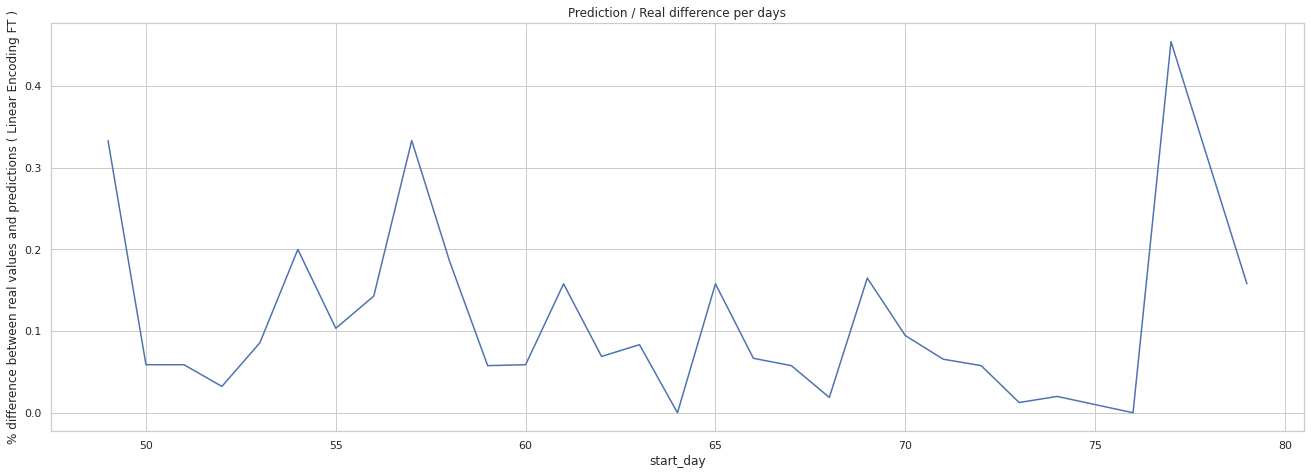

In [102]:
test_copy = df.loc[(df.dataset == "test") & (df.duration.notnull())].copy()
test_copy["preds"] = linear_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Linear Encoding FT )")

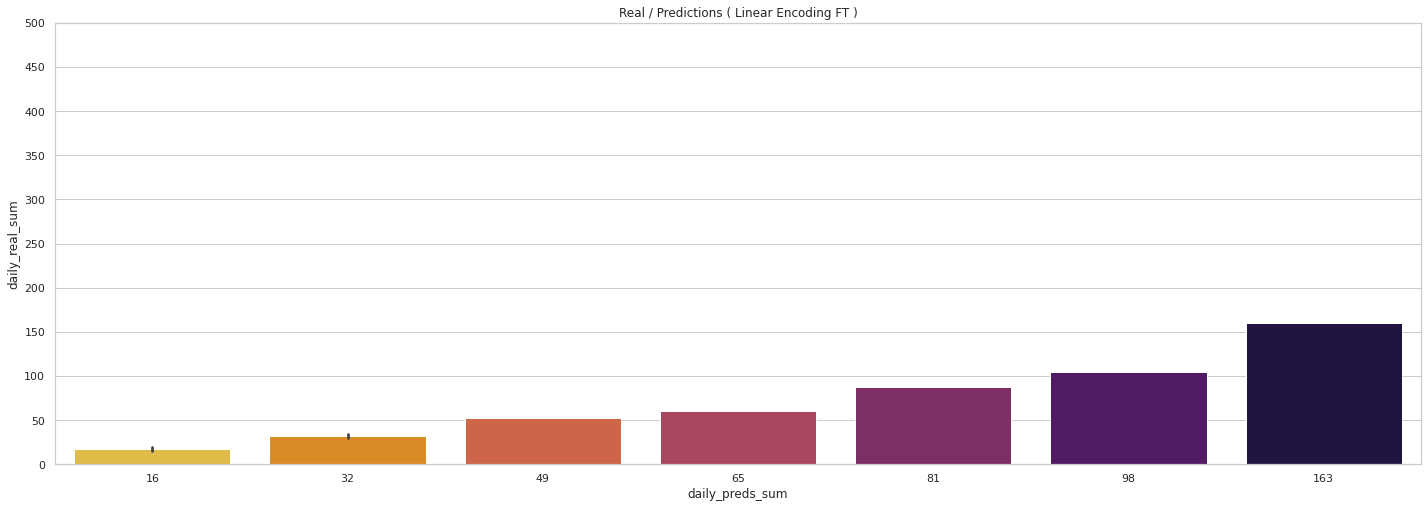

In [103]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Linear Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Linear Encoding FT )')

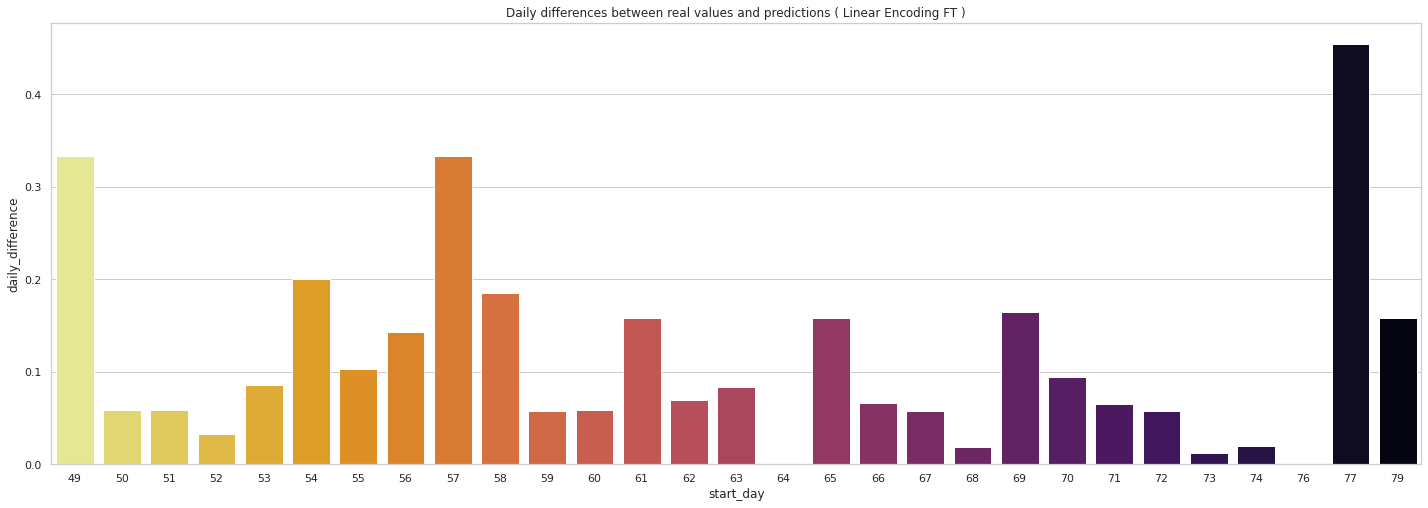

In [104]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Linear Encoding FT )")

### LightGBM

In [109]:
#df = df.drop(["DESCRIPTION_x", "DESCRIPTION_y"], 1)
#df.fillna(0, inplace = True)
for i in df.columns:
  if i in CATEGORICAL_FEATURES:
    df[i] = df[i].astype(str)
    df[i].fillna(0, inplace = True)
    df[i] = df[i].astype("category")
train = df.loc[(df.dataset == "train") & (df.duration.notnull())]
test = df.loc[(df.dataset == "test") & (df.duration.notnull())]
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")

In [110]:

### Train & Validation 
from sklearn.model_selection import train_test_split
FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES
X = train.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES]
y = train.duration
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)

import lightgbm as lgb

model = lgb.LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=CATEGORICAL_FEATURES)

preds = model.predict(X_val)
preds[preds<0] = 0
val_result = mean_squared_error(y_val, preds, squared= False)
val_result

3.1205692462154757

In [111]:
model.fit(X, y)
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES])
lgb_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_mae = mae(test.duration, real_preds)
lgb_r2 = r2_score(test.duration, real_preds)


lgb_r2

0.22357777778204302

In [112]:
results = pd.DataFrame(y_val.values, columns = ["real"])
results["preds"] = preds
a = results.reset_index()
a.head(10)

,index,real,preds
0,0,19.0,16.612795
1,1,15.0,16.054293
2,2,18.0,13.867749
3,3,16.0,14.768176
4,4,19.0,15.931045
5,5,15.0,17.438002
6,6,15.0,15.848693
7,7,14.0,15.401952
8,8,14.0,16.186759
9,9,21.0,16.289573


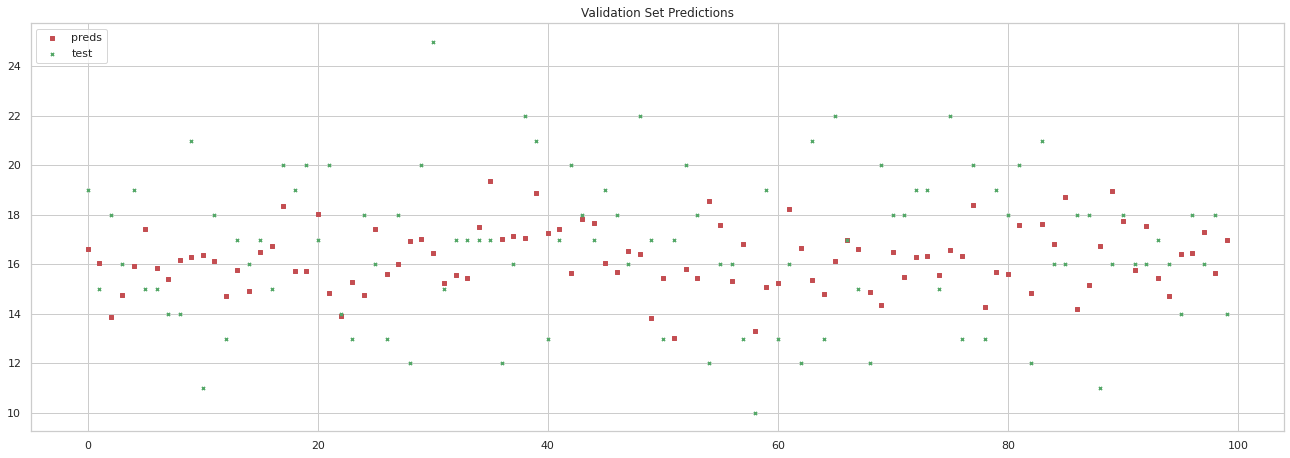

In [113]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20,7))
ax1 = fig.add_subplot(111)

ax1.scatter(a["index"][:100], a["preds"].values[:100], s=10, c='r', marker="s", label='preds') # we can define number of rows we want to see in the plot as we wish to see.
ax1.scatter(a["index"][:100], a["real"].values[:100], s=10, c='g', marker="x", label='test')
plt.legend(loc='upper left')
plt.title("Validation Set Predictions")
plt.show()

In [114]:
### Parameter Optimization
params = {
        'min_child_weight': [1, 5, 10,15],
        'colsample_bytree': [0.5, 0.7, 0.99],
        'num_leaves': [4,8,16,32,64,80],
        'num_iterations': [100,500,1000],
        'max_depth': [3, 4, 5,6,7, 10],
        "reg_lambda" : [0.2,0.5, 1, 1.5]
        }
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
param_comb = 6

kf = StratifiedKFold(n_splits = 5)

random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=5, scoring='neg_mean_squared_error',  cv=kf.split(X,y), verbose=1, random_state=42 )

# Here we go
random_search.fit(X, y)
import lightgbm as lgb

model = lgb.LGBMRegressor(**random_search.best_params_)
model.fit(X_train, y_train, categorical_feature=CATEGORICAL_FEATURES)

preds = model.predict(X_val)
val_result2 = mean_squared_error(y_val, preds, squared= False)
val_result2
print(random_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'reg_lambda': 1, 'num_leaves': 16, 'num_iterations': 500, 'min_child_weight': 10, 'max_depth': 4, 'colsample_bytree': 0.5}


In [115]:
import lightgbm as lgb

model = lgb.LGBMRegressor(**random_search.best_params_)
model.fit(X_train, y_train, categorical_feature=CATEGORICAL_FEATURES)

preds = model.predict(X_val)
val_result2 = mean_squared_error(y_val, preds, squared= False)
val_result2
##Test
model.fit(X, y)

real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES])
lgb_tuned_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_tuned_mae = mae(test.duration, real_preds)
lgb_tuned_r2 = r2_score(test.duration, real_preds)

In [116]:
results = pd.DataFrame(test.duration.values, columns = ["real"])
results["preds"] = real_preds
a = results.reset_index()
a.head()


,index,real,preds
0,0,17.0,17.893535
1,1,18.0,14.031389
2,2,18.0,16.483224
3,3,19.0,16.795478
4,4,19.0,17.327703


In [117]:
df["start_month"] = df.icu_start.dt.month
df["start_week"] = df.icu_start.dt.week
df["start_day"] = df.icu_start.dt.dayofyear

test["start_month"] = test.icu_start.dt.month
test["start_week"] = test.icu_start.dt.week
test["start_day"] = test.icu_start.dt.dayofyear

Text(0, 0.5, '% difference between real values and predictions')

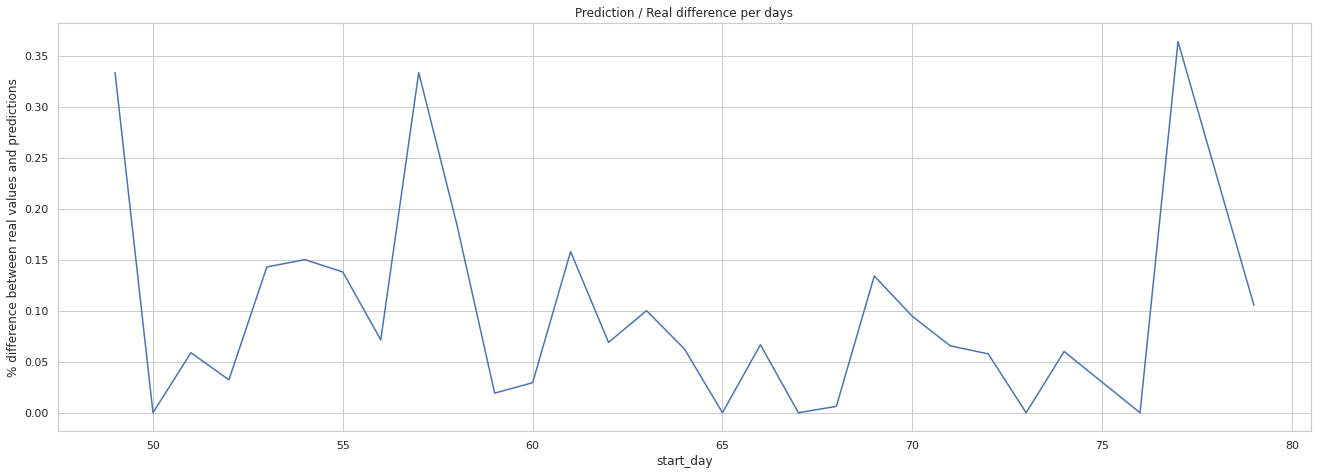

In [118]:
test["preds"] = a.preds.values
test["daily_preds_sum"] = test.groupby("start_day")["preds"].transform("sum").astype(int)
test["daily_real_sum"] = test.groupby("start_day")["duration"].transform("sum")
temp = test.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions")

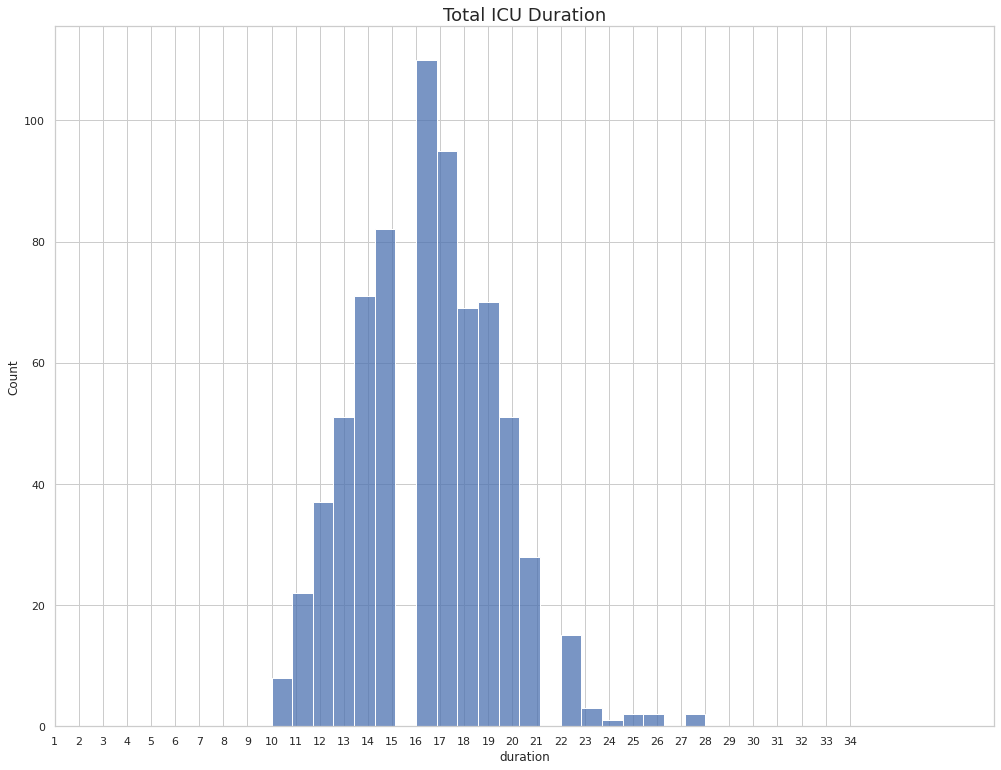

In [119]:
plt.figure(figsize = (15,12))
sns.histplot(data = df, x = "duration")
plt.xticks(np.arange(1,35,1))
plt.xlim(1,40)
plt.title('Total ICU Duration', fontsize = 18)
plt.show()

Text(0, 0.5, 'frequency')

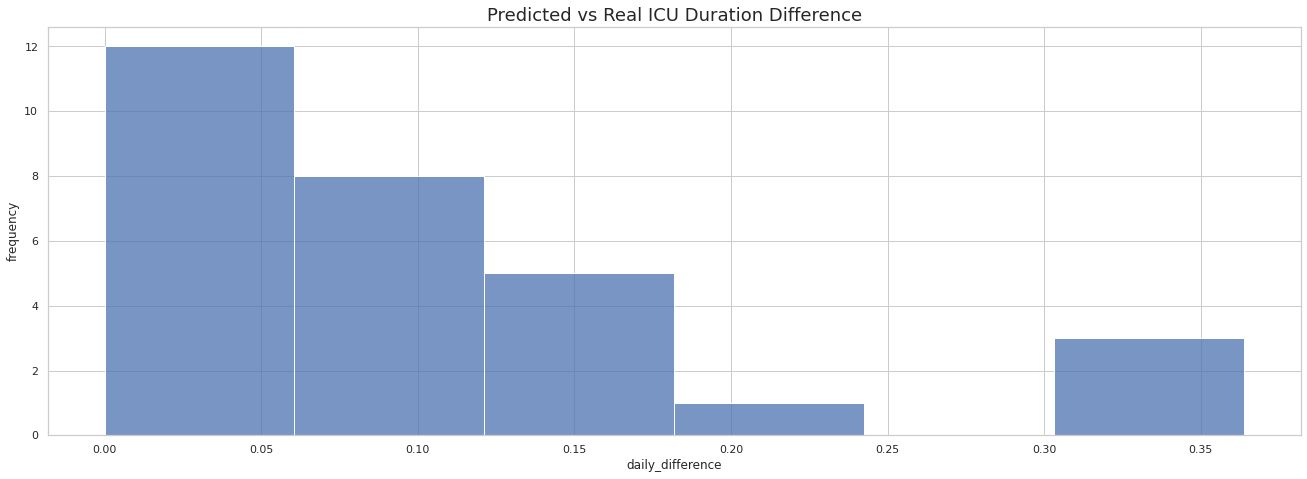

In [120]:
plt.figure(figsize = (20,7))
sns.histplot(data = temp, x = "daily_difference")
plt.title("Predicted vs Real ICU Duration Difference", fontsize = 18)
plt.ylabel("frequency")

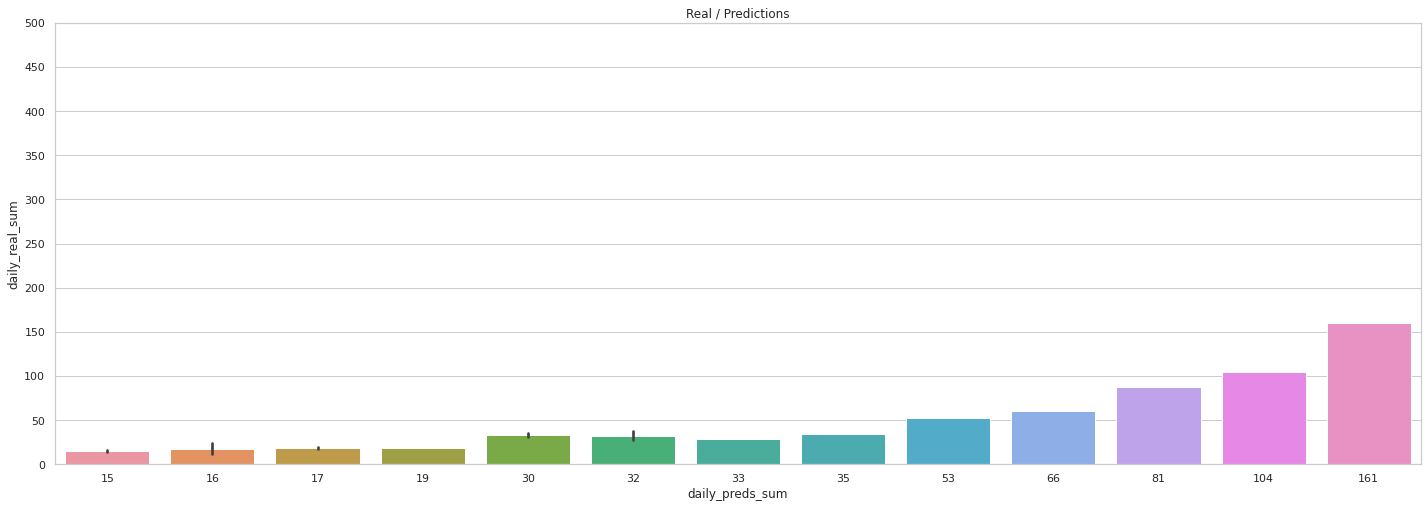

In [121]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20])
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions')

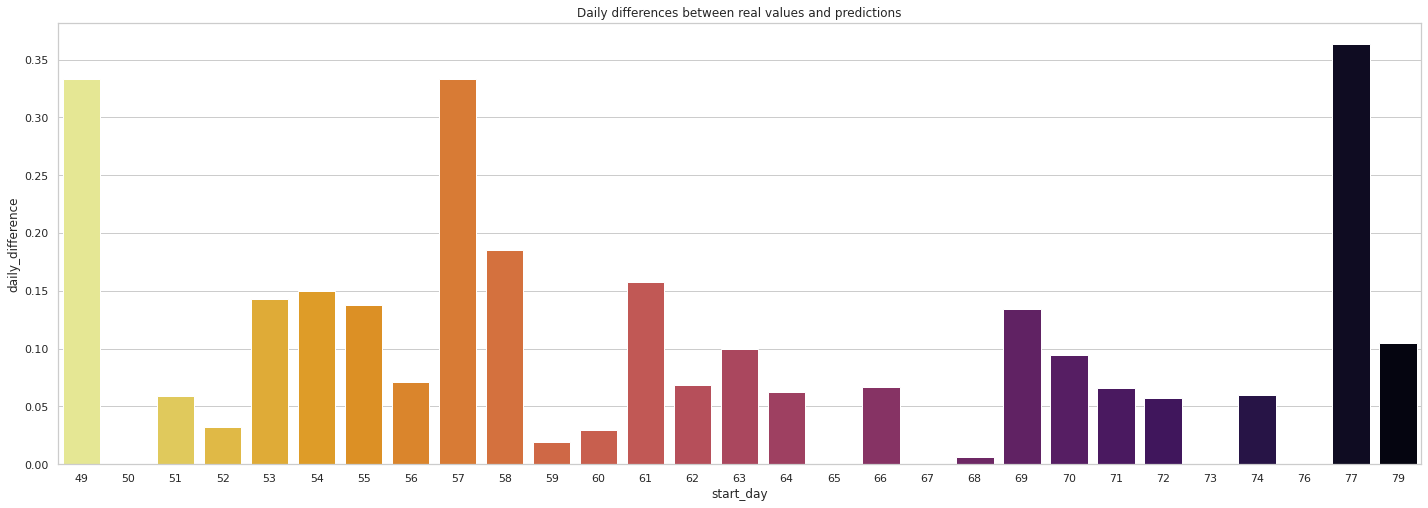

In [122]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions")

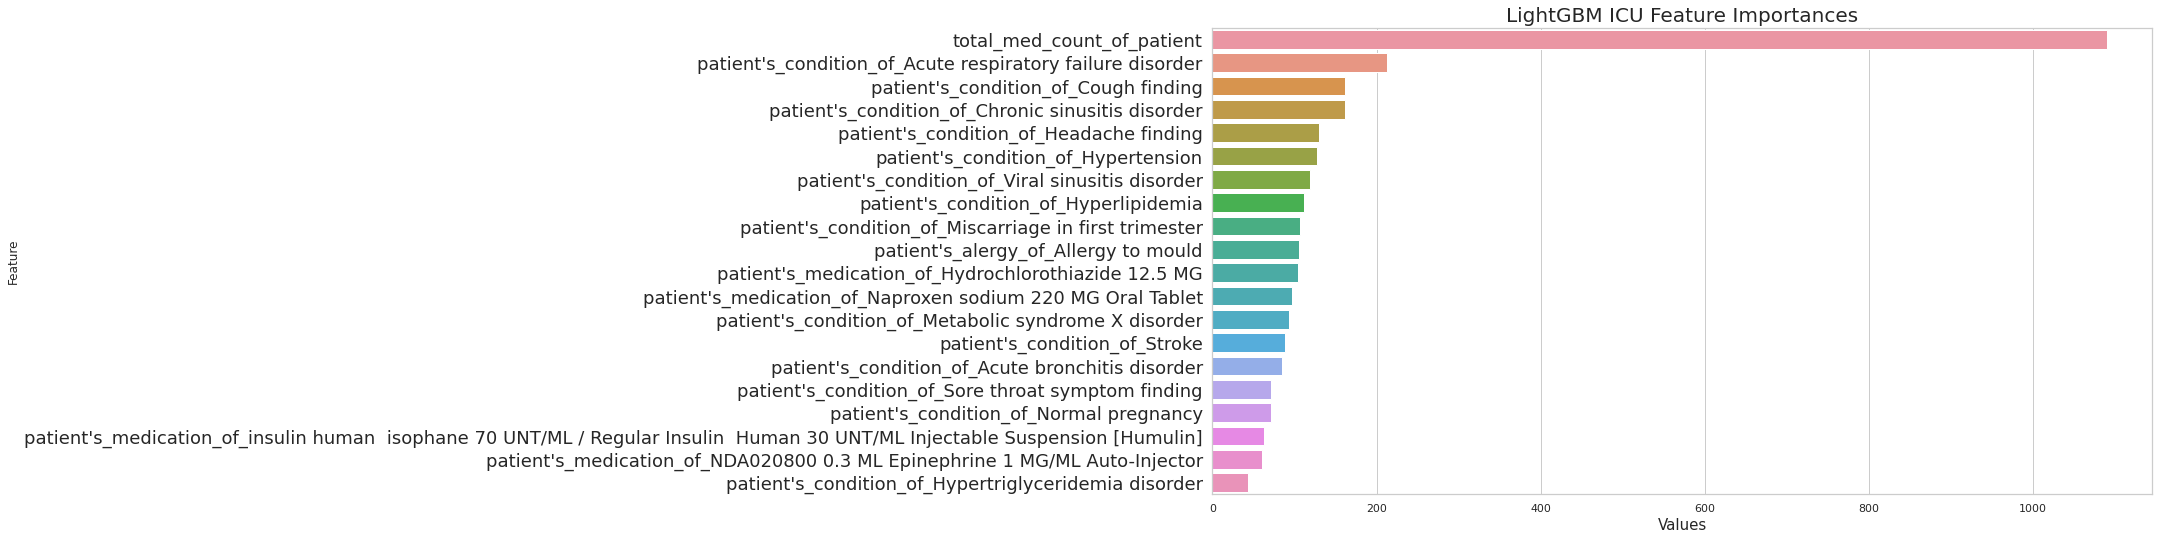

<Figure size 432x288 with 0 Axes>

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 8))
p = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:20])
_, ylabels = plt.yticks()
p.set_yticklabels(ylabels, size=18)
p.set_xlabel("Values", size = 15)

plt.title('LightGBM ICU Feature Importances', fontsize = 20)
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importance-hospital.png')

### Our results were like this :

In [124]:
before_optimization = pd.DataFrame({"r2" : [linear_r2, periodic_r2, lgb_r2],
              "mae" : [linear_mae, period_mae, lgb_mae],
              "rmse" : [linear_rms, periodic_rms, lgb_rmse]}, index = ["Transformer - Linear Encoding", "Transformer - Periodic Encoding",
                     "LightGBM"]) # parameter needs more iterations
before_optimization

,r2,mae,rmse
Transformer - Linear Encoding,-11.174101,10.222992,10.670382
Transformer - Periodic Encoding,-11.174101,13.433081,13.776595
LightGBM,0.223578,2.076450,2.694701


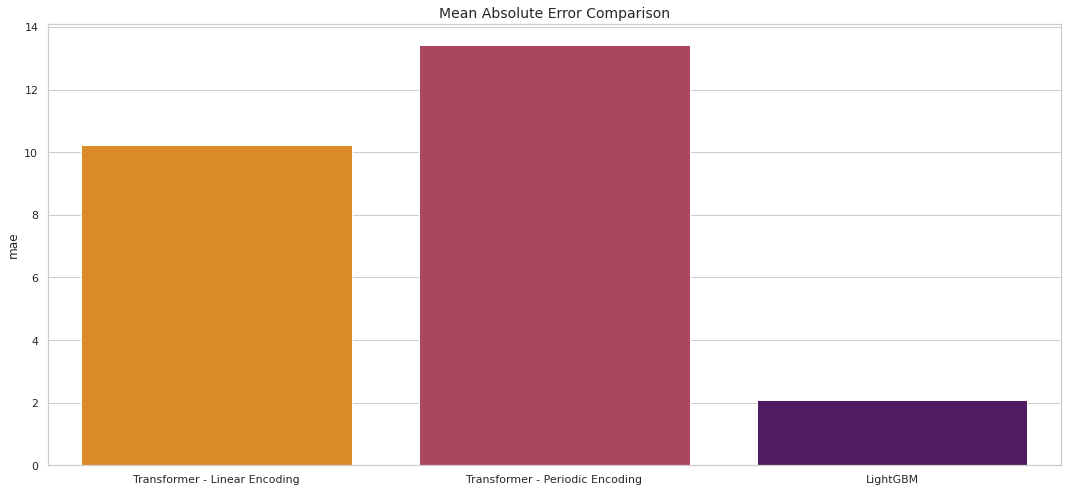

In [125]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


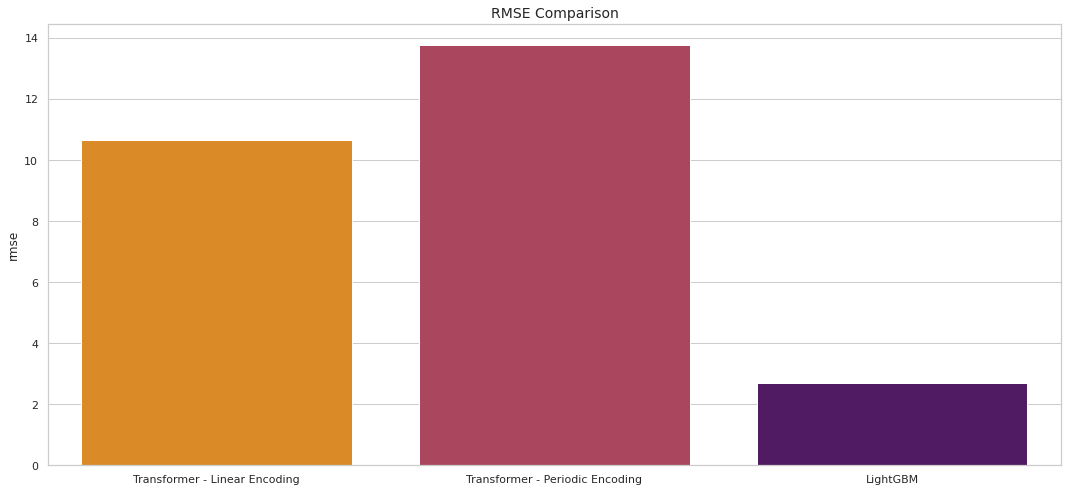

In [126]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


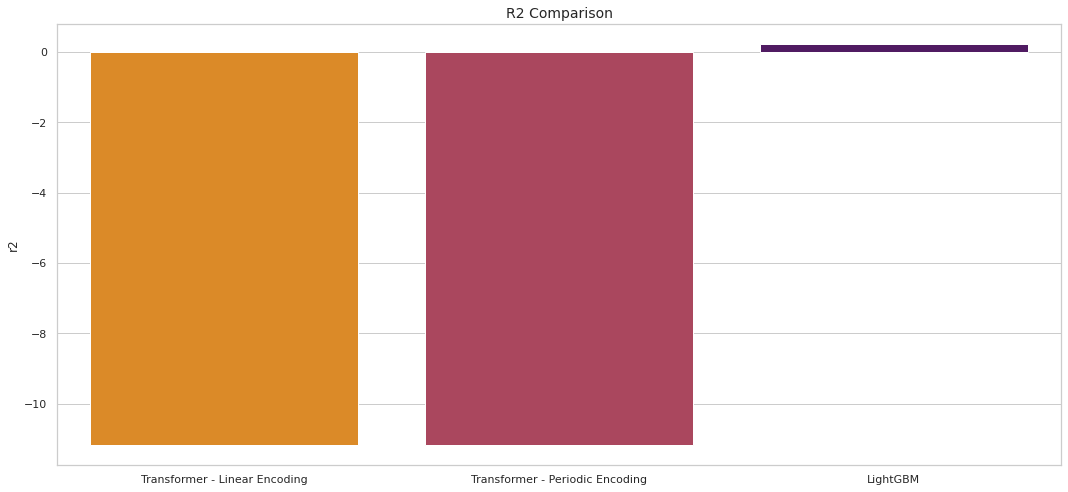

In [127]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()


### After optimization:

In [128]:
after_optimization = pd.DataFrame({"r2" : [linear_tuned_r2, periodic_tuned_r2, lgb_tuned_r2],
              "mae" : [linear_tuned_mae, periodic_tuned_mae, lgb_tuned_mae],
              "rmse" : [linear_tuned_rms, periodic_tuned_rms, lgb_tuned_rmse]}, index = ["Transformer - Linear Encoding TUNED", "Transformer - Periodic Encoding TUNED",
                     "LightGBM TUNED"]) # parameter needs more iterations
after_optimization

,r2,mae,rmse
Transformer - Linear Encoding TUNED,-0.001302,2.368755,3.060160
Transformer - Periodic Encoding TUNED,-0.018768,2.368472,3.086734
LightGBM TUNED,0.183158,2.150466,2.763953


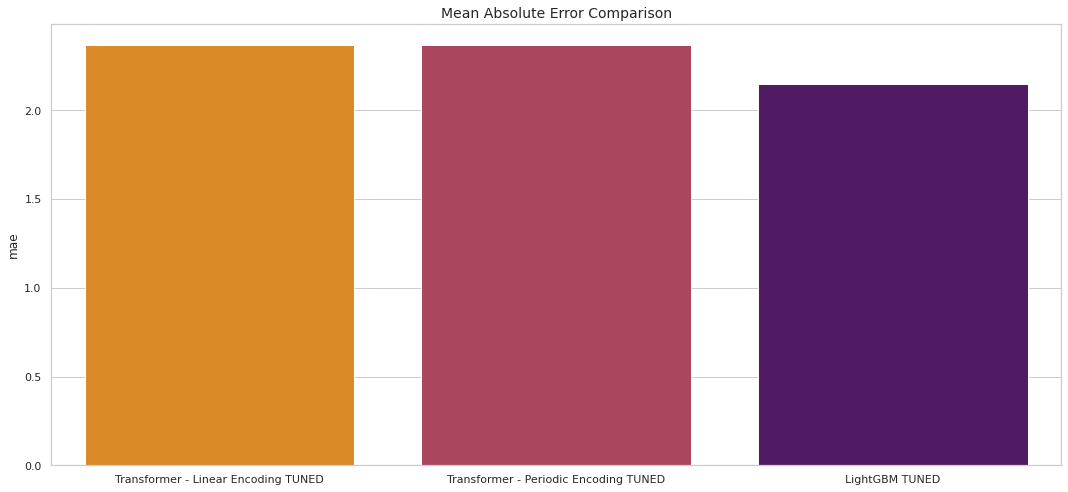

In [129]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


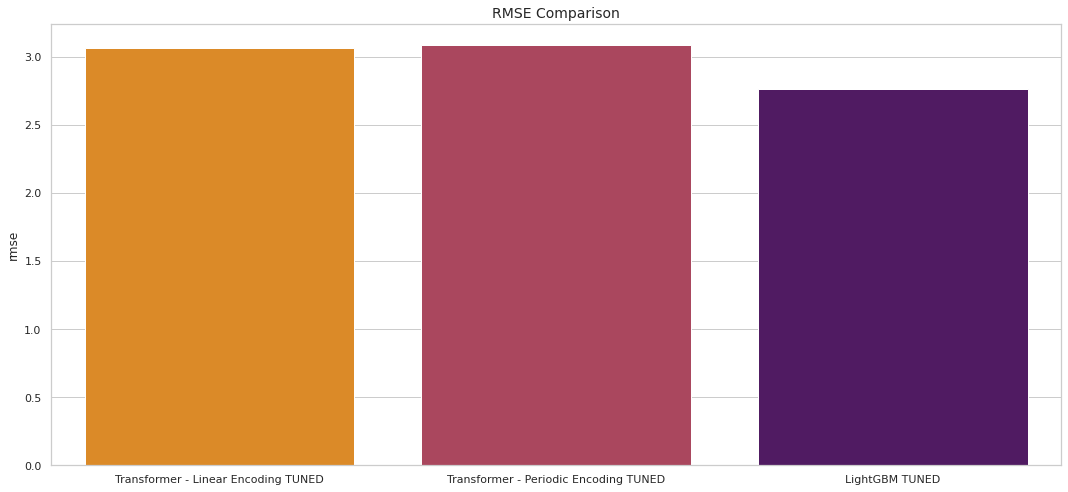

In [130]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


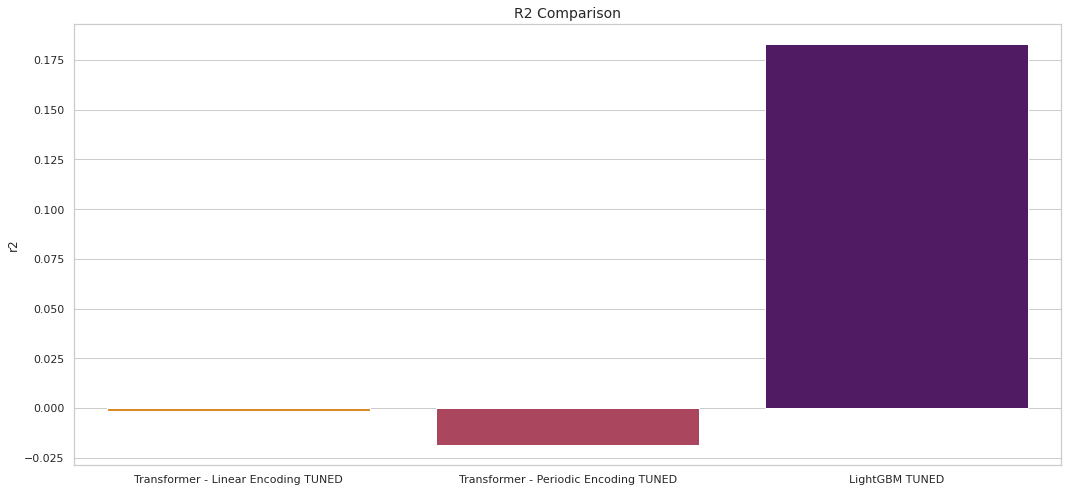

In [131]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()
